# 0. Import Modules / Settings / Parameters

In [ ]:
import os
import time
import pickle
import datetime
import logging

import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

# Set up the device for GPU / CPU computation
print(f"Is GPU available: {torch.cuda.is_available()}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Mount drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/SMU MITB/4th Term/3. CS612: AI System Evaluation/CS612 AISE Group Project/2. Backdoor Detector/Darius/'

Is GPU available: True
Mounted at /content/drive


In [ ]:
# Set base seed
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)

# Selected dataset
dataset = datasets.CIFAR10
dataset_name = "CIFAR10"
IMG_ROWS = 32
IMG_COLS = 32
IMG_COLOR = 3

# Parameters
PARAMS = {
  'INPUT_SHAPE': (IMG_COLOR, IMG_ROWS, IMG_COLS),
  'LR': 0.001,
  'LAMBDA': 0.1,          # Regularization weight for the mask; higher lambda, more weight in controlling the trigger size
  'EPOCHS': 40,           # Number of epochs for optimization
  'ITER': 150,            # Number of iterations per epoch
  'BATCH_SIZE': 64,       # Batch size for each iteration
  'PATIENCE': 75,         # Number of batch iterations before early stopping
  'INTERVAL': 40,         # The interval at which to print the total loss during optimization
  'CMAP_P': 'viridis',    # Color map for visualizing the pattern; consider the IMG_COLOR
  'CMAP_M': 'gray',       # Color map for visualizing the mask
  'CMAP_T': 'viridis',    # Color map for visualizing the trigger; consider the IMG_COLOR
  'BG_COLOR_P': 'black',  # Background color for the pattern plot
  'BG_COLOR_M': 'black',  # Background color for the mask plot
  'BG_COLOR_T': 'black',  # Background color for the trigger plot
  'NUM_TRIALS': 3,        # Number of reverse-engineered triggers per target label
  'PATTERN_MIN': 0,       # Min pixel of initial pattern
  'PATTERN_MAX': 1,       # Max pixel of initial pattern
  'MASK_MIN': 0,          # Min pixel of initial mask
  'MASK_MAX': 1,          # Max pixel of initial mask
  'MAD_THRESHOLD': 2      # Threshold for the anomaly index (MAD outlier detection)
}

# 1. Load Dataset and Model

In [ ]:
# Define the transformations for the dataset
transform = transforms.Compose([
  transforms.ToTensor(),                  # Convert to tensor
  transforms.Normalize((0.5,), (0.5,))    # Normalize
])

# Load training data
trainset = dataset(root = './data', train = True, download = True, transform = transform)
trainloader = DataLoader(trainset, batch_size = PARAMS['BATCH_SIZE'], shuffle = True)

# Load testing data
testset = dataset(root = './data', train = False, download = True, transform = transform)
testloader = DataLoader(testset, batch_size = PARAMS['BATCH_SIZE'], shuffle = False)

100%|██████████| 170498071/170498071 [00:04<00:00, 42604791.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Define the model architecture
class CIFAR10Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2) # Output: 64 x 16 x 16

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2) # Output: 128 x 8 x 8

    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.pool3 = nn.MaxPool2d(2, 2) # Output: 256 x 4 x 4

    self.fc1 = nn.Linear(256 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool1(x)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = self.conv5(x)
    x = F.relu(x)
    x = self.conv6(x)
    x = F.relu(x)
    x = self.pool3(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)

    output = x
    return output


# Load the model to the specified device (GPU / CPU)
model = CIFAR10Net().to(device)

# Load the model weights
model_name = '_Test Cases/Public/model5/cifar10_bd.pt'
model_filepath = filepath + model_name
model.load_state_dict(torch.load(model_filepath))
model.eval()

CIFAR10Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

# 2. Reverse Engineer Triggers

In [ ]:
class ReverseEngineerTrigger:
  def __init__(self, model, target_label, input_shape, learning_rate,
               lambda_reg, initial_pattern, initial_mask):
    """
    Initialize the ReverseEngineerTrigger instance.

    Parameters:
    - model (torch.nn.Module): The pre-trained model to analyze.
    - target_label (int): The target label for misclassification.
    - input_shape (tuple): The shape of the input images.
    - learning_rate (float): Learning rate for the optimizer.
    - lambda_reg (float): Regularization weight to promote mask sparsity.
    - initial_pattern (torch.Tensor): Initial trigger pattern.
    - initial_mask (torch.Tensor): Initial mask.
    """

    self.model = model
    self.target_label = target_label
    self.learning_rate = learning_rate
    self.lambda_reg = lambda_reg
    self.pattern = torch.nn.Parameter(initial_pattern).to(device)
    self.mask = torch.nn.Parameter(initial_mask).to(device)
    self.optimizer = optim.Adam([self.pattern, self.mask], lr = self.learning_rate)


  def objective_function(self, x, y_target):
    """
    Define the objective function for optimization.

    Parameters:
    - x (torch.Tensor): Input image batch.
    - y_target (torch.Tensor): Target label for misclassification.

    Returns:
    - tuple (of torch.Tensor): The total loss, cross-entropy loss and regularization loss.
    """

    # Apply the trigger (pattern and mask) to the input images
    x_wtrigger = (1 - self.mask[None, None, :, :]) * x + self.mask[None, None, :, :] * self.pattern

    # Compute the cross-entropy loss for misclassification
    logits = self.model(x_wtrigger)
    loss_ce = F.cross_entropy(logits, y_target)

    # Compute the regularization loss (based on the L1 norm) for the mask to promote sparsity
    loss_reg = torch.sum(torch.abs(self.mask))

    # Total loss is a combination of cross-entropy and regularization loss
    loss = loss_ce + self.lambda_reg * loss_reg
    return loss, loss_ce, loss_reg


  def optimize_trigger(self, trainset, target_label,
                       epochs, iterations, batch_size,
                       patience, seed, log_interval):
    """
    Optimize the trigger using mini-batch gradient descent.

    Parameters:
    - trainset (Dataset): PyTorch dataset containing training data and labels.
    - target_label (int): The target label for misclassification.
    - epochs (int): Number of epochs for optimization.
    - iterations (int): Number of iterations per epoch.
    - batch_size (int): Batch size for each iteration.
    - patience (int): Number of batch iterations to wait for improvement before stopping.
    - seed (int): Base seed for reproducibility.
    - log_interval (int): The interval at which to print the total loss.

    Returns:
    - tuple: The optimized pattern and mask with the lowest batch loss.
    """

    best_loss = float('inf')
    patience_counter = 0
    best_pattern = self.pattern.clone().detach()      # Use the current pattern as the initial best
    best_mask = self.mask.clone().detach()            # Use the current mask as the initial best

    seed_counter = 0
    for epoch in range(epochs):
      for i in range(iterations):

        # Adjust the seed for each batch iteration
        torch.manual_seed(seed + i + epoch * iterations)

        # Initialize accumulated tensors for the batch data
        accumulated_x = torch.Tensor().to(device)

        # Keep sampling batches until we get enough samples
        while len(accumulated_x) < batch_size:

          # Adjust the seed within the accumulation loop
          torch.manual_seed(seed + i + epoch * iterations + seed_counter)

          # Extract the only batch
          sampler = RandomSampler(trainset, replacement = True, num_samples = batch_size)
          single_batch_loader = DataLoader(trainset, batch_size = batch_size, sampler = sampler)
          x, y = next(iter(single_batch_loader))

          # Select only those images where the true label is not equal to the target label
          selected_indices = (y != target_label).nonzero(as_tuple = True)[0]
          selected_x = x[selected_indices].to(device)

          accumulated_x = torch.cat((accumulated_x, selected_x), 0)[:batch_size]

          seed_counter += 1

        # At this point, accumulated_x has the intended batch size
        # Get a batch of labels where every label is set to the target label
        y_target = torch.full((batch_size,), target_label, dtype = torch.long).to(device)

        self.optimizer.zero_grad()                    # Zero out any accumulated gradients
        loss, loss_ce, loss_reg = self.objective_function(accumulated_x, y_target)

        loss.backward()                               # Compute gradients
        self.optimizer.step()                         # Update pattern and mask

        # Print progress
        if i % log_interval == 0:
          print(f"Epoch {epoch}, Batch iteration {i}:\nTotal loss: {loss.item():.4f}\nCross-entropy loss: {loss_ce.item():.4f}\nRegularization loss: {loss_reg.item():.4f}\n")

        # Check if the current loss is better than the best loss
        if loss.item() < best_loss:
          best_loss = loss.item()
          best_pattern = self.pattern.clone().detach()
          best_mask = self.mask.clone().detach()
          patience_counter = 0
        else:
          patience_counter += 1

          # Early stopping if the loss does not improve for a certain number of batch iterations
          if patience_counter >= patience:
            print("Early stopping triggered.")
            self.pattern.data = best_pattern.data
            self.mask.data = best_mask.data
            return self.pattern, self.mask

    # If loop ends without early stopping, update pattern and mask with the best ones
    self.pattern.data = best_pattern.data
    self.mask.data = best_mask.data

    return self.pattern, self.mask


  def visualize_save_trigger(self, cmap_p, cmap_m, cmap_t,
                             bg_color_p, bg_color_m, bg_color_t,
                             plot_fig = True, save_fig = False, save_path = None):
    """
    Visualize and/or save the pattern, mask and trigger. Default is to visualize only.

    Parameters:
    - cmap_p (str): Color map for visualizing the pattern.
    - cmap_m (str): Color map for visualizing the mask.
    - cmap_t (str): Color map for visualizing the trigger.
    - bg_color_p (str): Background color for the pattern plot.
    - bg_color_m (str): Background color for the mask plot.
    - bg_color_t (str): Background color for the trigger plot.
    - plot_fig (bool): Whether to plot the trigger figure. Default is True.
    - save_fig (bool): Whether to save the trigger figure. Default is False.
    - save_path (str): The path where the trigger image will be saved (as a PNG file).
                       Default is None. If save_fig is True, the save_path needs to be included.
    """

    # Convert the tensors to numpy arrays for visualization
    pattern_data = self.pattern.detach().cpu().numpy()
    mask_data = self.mask.detach().cpu().numpy()

    plt.figure(figsize = (12, 5))

    # Plotting the Pattern
    ax1 = plt.subplot(1, 3, 1)
    plt.imshow(pattern_data.transpose(1, 2, 0), vmin = 0, vmax = 1, cmap = cmap_p)       # Convert from CHW to HWC for visualization
    plt.title("Pattern")
    plt.colorbar(fraction = 0.046, pad = 0.04, boundaries = np.linspace(0, 1, 11), ticks = np.linspace(0, 1, 11))
    plt.axis('off')
    ax1.set_facecolor(bg_color_p)

    # Plotting the Mask
    ax2 = plt.subplot(1, 3, 2)
    plt.imshow(mask_data, vmin = 0, vmax = 1, cmap = cmap_m)
    plt.title("Mask")
    plt.colorbar(fraction = 0.046, pad = 0.04, boundaries = np.linspace(0, 1, 11), ticks = np.linspace(0, 1, 11))
    plt.axis('off')
    ax2.set_facecolor(bg_color_m)

    # Plotting the Trigger
    ax3 = plt.subplot(1, 3, 3)
    combined_trigger = pattern_data * mask_data[None, :, :]
    plt.imshow(combined_trigger.transpose(1, 2, 0), vmin = 0, vmax = 1, cmap = cmap_t)   # Convert from CHW to HWC for visualization
    plt.title("Trigger")
    plt.colorbar(fraction = 0.046, pad = 0.04, boundaries = np.linspace(0, 1, 11), ticks = np.linspace(0, 1, 11))
    plt.axis('off')
    ax3.set_facecolor(bg_color_t)

    plt.tight_layout()

    # Show the plot if plot_fig is True
    if plot_fig:
      plt.show()

    # Save the figure if save_fig is True and save_path is not None
    if save_fig and save_path is not None:
      plt.savefig(save_path, bbox_inches = 'tight')
      plt.close()


def reverse_engineer_triggers_for_all_labels(trainset, trainloader, model, params, seed):
  """
  Reverse-engineer triggers for all labels in the dataset.

  Parameters:
  - trainset (Dataset): Dataset containing training data and labels.
  - trainloader (DataLoader): DataLoader for training data.
  - model (torch.nn.Module): The pre-trained model to analyze.
  - params (dict): Dictionary of parameters.
  - seed (int): Base seed for reproducibility.

  Returns:
  - dict: Dictionary containing a list of reverse-engineered triggers for each label.
  """

  # Get all class labels in the dataset
  labels = torch.unique(torch.tensor(trainloader.dataset.targets))

  # Initialize dictionary to hold the reverse-engineered triggers for each label
  triggers = {}
  total_start_time = time.time()

  # Iterate through all the class labels
  for label in labels:

    # Initialize list for the reverse-engineered triggers
    triggers[label.item()] = []

    # Run optimization for different initial triggers and masks
    for i in range(params['NUM_TRIALS']):
      print(f"\n----- Optimizing for label {label.item()}, trial {i+1}/{params['NUM_TRIALS']} -----\n")

      # Modify the seed for each label and trial
      torch.manual_seed(seed + label.item() * params['NUM_TRIALS'] + i)

      # Create random initial trigger pattern and mask
      pattern_data = torch.rand(params['INPUT_SHAPE'], requires_grad = True).to(device)
      mask_data = torch.rand(params['INPUT_SHAPE'][1:], requires_grad = True).to(device)

      initial_pattern = pattern_data * (params['PATTERN_MAX'] - params['PATTERN_MIN']) + params['PATTERN_MIN']
      initial_mask = mask_data * (params['MASK_MAX'] - params['MASK_MIN']) + params['MASK_MIN']

      # Create trigger instance
      trigger_engineer = ReverseEngineerTrigger(
        model = model,
        target_label = label.item(),
        input_shape = params['INPUT_SHAPE'],
        learning_rate = params['LR'],
        lambda_reg = params['LAMBDA'],
        initial_pattern = initial_pattern,
        initial_mask = initial_mask
      )

      start_time = time.time()

      # Optimize the trigger
      trigger_engineer.optimize_trigger(
        trainset = trainset,
        target_label = label.item(),
        epochs = params['EPOCHS'],
        iterations = params['ITER'],
        batch_size = params['BATCH_SIZE'],
        patience = params['PATIENCE'],
        seed = seed,
        log_interval = params['INTERVAL']
      )

      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"Optimization time: {elapsed_time:.2f} seconds\n")

      # Visualise the optimized trigger
      trigger_engineer.visualize_save_trigger(
        cmap_p = params['CMAP_P'],
        cmap_m = params['CMAP_M'],
        cmap_t = params['CMAP_T'],
        bg_color_p = params['BG_COLOR_P'],
        bg_color_m = params['BG_COLOR_M'],
        bg_color_t = params['BG_COLOR_T']
      )

      # Append optimized trigger to the list
      triggers[label.item()].append(trigger_engineer)

  total_end_time = time.time()
  total_elapsed_time = total_end_time - total_start_time
  minutes = int(total_elapsed_time // 60)
  seconds = int(total_elapsed_time % 60)
  print(f"\n\nTotal optimization time: {minutes} minutes, {seconds} seconds.")

  # Reset seed
  torch.manual_seed(seed)

  return triggers


----- Optimizing for label 0, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 99.0303
Cross-entropy loss: 49.6226
Regularization loss: 494.0773

Epoch 0, Batch iteration 40:
Total loss: 71.1269
Cross-entropy loss: 22.0492
Regularization loss: 490.7770

Epoch 0, Batch iteration 80:
Total loss: 55.7222
Cross-entropy loss: 6.9621
Regularization loss: 487.6013

Epoch 0, Batch iteration 120:
Total loss: 52.1250
Cross-entropy loss: 3.8952
Regularization loss: 482.2986

Epoch 1, Batch iteration 0:
Total loss: 49.4059
Cross-entropy loss: 1.6763
Regularization loss: 477.2960

Epoch 1, Batch iteration 40:
Total loss: 48.9315
Cross-entropy loss: 1.9980
Regularization loss: 469.3347

Epoch 1, Batch iteration 80:
Total loss: 46.9436
Cross-entropy loss: 0.9192
Regularization loss: 460.2446

Epoch 1, Batch iteration 120:
Total loss: 45.3966
Cross-entropy loss: 0.3605
Regularization loss: 450.3616

Epoch 2, Batch iteration 0:
Total loss: 45.7065
Cross-entropy loss: 1.4642
Regularization loss

Early stopping triggered.
Optimization time: 275.35 seconds



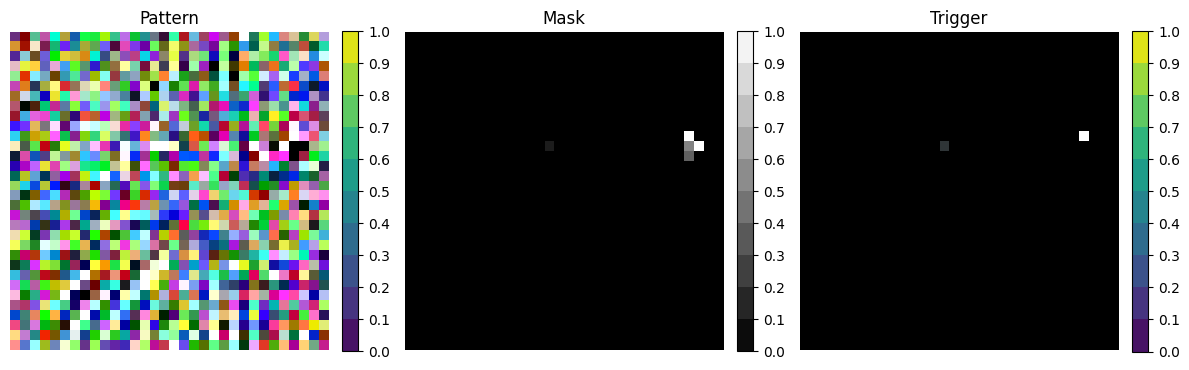


----- Optimizing for label 0, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 91.9744
Cross-entropy loss: 41.1684
Regularization loss: 508.0602

Epoch 0, Batch iteration 40:
Total loss: 71.5557
Cross-entropy loss: 21.1026
Regularization loss: 504.5308

Epoch 0, Batch iteration 80:
Total loss: 58.6147
Cross-entropy loss: 8.4773
Regularization loss: 501.3740

Epoch 0, Batch iteration 120:
Total loss: 54.3862
Cross-entropy loss: 4.7080
Regularization loss: 496.7817

Epoch 1, Batch iteration 0:
Total loss: 51.5402
Cross-entropy loss: 2.3416
Regularization loss: 491.9860

Epoch 1, Batch iteration 40:
Total loss: 50.4355
Cross-entropy loss: 2.0158
Regularization loss: 484.1969

Epoch 1, Batch iteration 80:
Total loss: 48.9916
Cross-entropy loss: 1.4758
Regularization loss: 475.1575

Epoch 1, Batch iteration 120:
Total loss: 47.0760
Cross-entropy loss: 0.5514
Regularization loss: 465.2455

Epoch 2, Batch iteration 0:
Total loss: 46.7501
Cross-entropy loss: 1.0454
Regularization loss

Epoch 24, Batch iteration 40:
Total loss: 0.7134
Cross-entropy loss: 0.0000
Regularization loss: 7.1339

Early stopping triggered.
Optimization time: 183.33 seconds



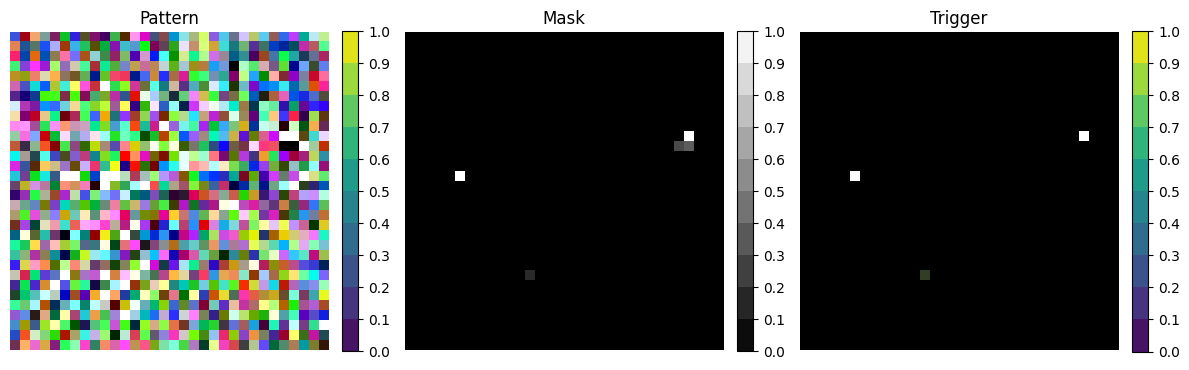


----- Optimizing for label 0, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 94.3602
Cross-entropy loss: 44.4774
Regularization loss: 498.8274

Epoch 0, Batch iteration 40:
Total loss: 64.8933
Cross-entropy loss: 15.2535
Regularization loss: 496.3982

Epoch 0, Batch iteration 80:
Total loss: 55.3747
Cross-entropy loss: 6.0578
Regularization loss: 493.1696

Epoch 0, Batch iteration 120:
Total loss: 52.6368
Cross-entropy loss: 3.8642
Regularization loss: 487.7262

Epoch 1, Batch iteration 0:
Total loss: 50.0901
Cross-entropy loss: 1.8628
Regularization loss: 482.2728

Epoch 1, Batch iteration 40:
Total loss: 50.0106
Cross-entropy loss: 2.6378
Regularization loss: 473.7279

Epoch 1, Batch iteration 80:
Total loss: 46.8112
Cross-entropy loss: 0.3775
Regularization loss: 464.3367

Epoch 1, Batch iteration 120:
Total loss: 46.2164
Cross-entropy loss: 0.8203
Regularization loss: 453.9606

Epoch 2, Batch iteration 0:
Total loss: 46.2582
Cross-entropy loss: 1.7003
Regularization loss

Early stopping triggered.
Optimization time: 270.90 seconds



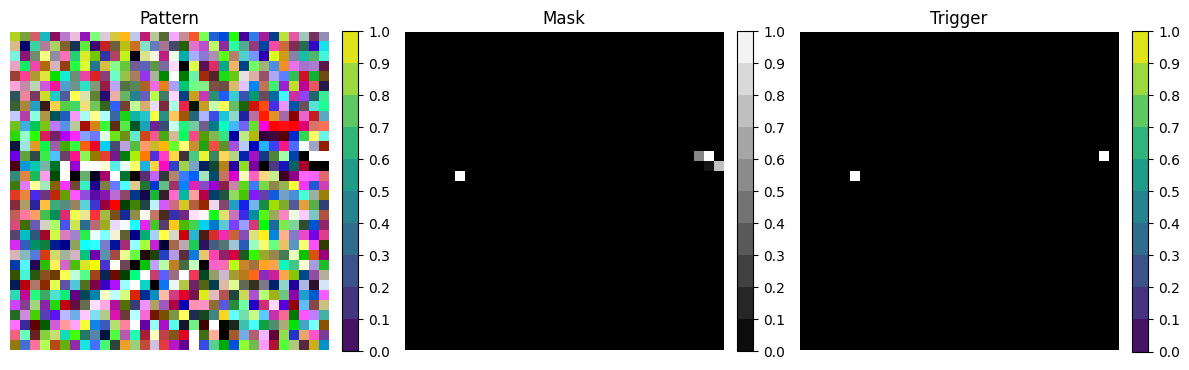


----- Optimizing for label 1, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 102.4319
Cross-entropy loss: 49.3391
Regularization loss: 530.9274

Epoch 0, Batch iteration 40:
Total loss: 67.4090
Cross-entropy loss: 14.6098
Regularization loss: 527.9919

Epoch 0, Batch iteration 80:
Total loss: 57.0117
Cross-entropy loss: 4.5868
Regularization loss: 524.2482

Epoch 0, Batch iteration 120:
Total loss: 55.1480
Cross-entropy loss: 3.3955
Regularization loss: 517.5245

Epoch 1, Batch iteration 0:
Total loss: 53.0604
Cross-entropy loss: 1.9554
Regularization loss: 511.0503

Epoch 1, Batch iteration 40:
Total loss: 51.8780
Cross-entropy loss: 1.7283
Regularization loss: 501.4972

Epoch 1, Batch iteration 80:
Total loss: 50.4466
Cross-entropy loss: 1.3416
Regularization loss: 491.0503

Epoch 1, Batch iteration 120:
Total loss: 49.0996
Cross-entropy loss: 1.1426
Regularization loss: 479.5702

Epoch 2, Batch iteration 0:
Total loss: 48.0969
Cross-entropy loss: 1.0229
Regularization los

Optimization time: 301.34 seconds



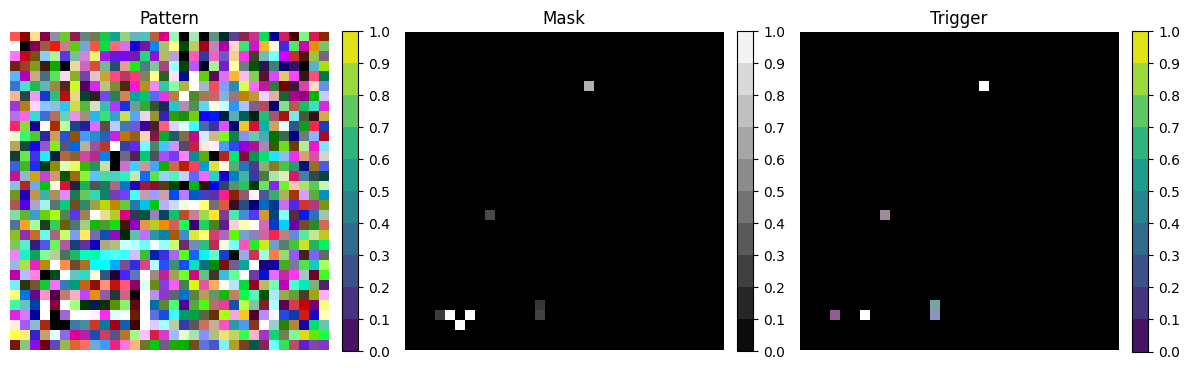


----- Optimizing for label 1, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 88.4112
Cross-entropy loss: 40.1998
Regularization loss: 482.1141

Epoch 0, Batch iteration 40:
Total loss: 61.0439
Cross-entropy loss: 13.3034
Regularization loss: 477.4052

Epoch 0, Batch iteration 80:
Total loss: 52.9875
Cross-entropy loss: 5.7586
Regularization loss: 472.2891

Epoch 0, Batch iteration 120:
Total loss: 50.5930
Cross-entropy loss: 4.0710
Regularization loss: 465.2205

Epoch 1, Batch iteration 0:
Total loss: 47.2293
Cross-entropy loss: 1.3403
Regularization loss: 458.8904

Epoch 1, Batch iteration 40:
Total loss: 47.0274
Cross-entropy loss: 2.1175
Regularization loss: 449.0993

Epoch 1, Batch iteration 80:
Total loss: 45.6188
Cross-entropy loss: 1.8092
Regularization loss: 438.0961

Epoch 1, Batch iteration 120:
Total loss: 43.8459
Cross-entropy loss: 1.2156
Regularization loss: 426.3028

Epoch 2, Batch iteration 0:
Total loss: 42.7314
Cross-entropy loss: 0.9975
Regularization loss

Optimization time: 302.83 seconds



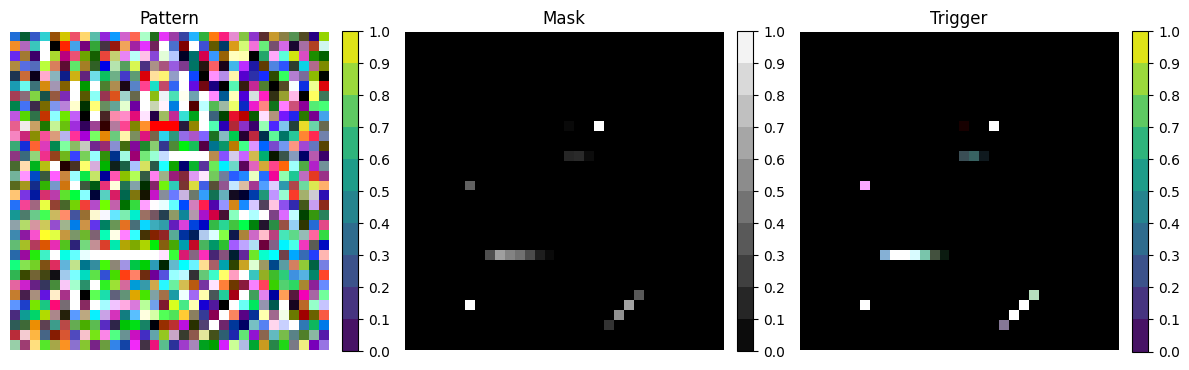


----- Optimizing for label 1, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 84.1063
Cross-entropy loss: 33.5020
Regularization loss: 506.0429

Epoch 0, Batch iteration 40:
Total loss: 60.7447
Cross-entropy loss: 10.5288
Regularization loss: 502.1590

Epoch 0, Batch iteration 80:
Total loss: 54.3079
Cross-entropy loss: 4.6779
Regularization loss: 496.3003

Epoch 0, Batch iteration 120:
Total loss: 51.6031
Cross-entropy loss: 2.8133
Regularization loss: 487.8980

Epoch 1, Batch iteration 0:
Total loss: 49.1296
Cross-entropy loss: 1.0793
Regularization loss: 480.5032

Epoch 1, Batch iteration 40:
Total loss: 50.7352
Cross-entropy loss: 3.7953
Regularization loss: 469.3997

Epoch 1, Batch iteration 80:
Total loss: 46.6216
Cross-entropy loss: 0.8889
Regularization loss: 457.3273

Epoch 1, Batch iteration 120:
Total loss: 45.2847
Cross-entropy loss: 0.8123
Regularization loss: 444.7238

Epoch 2, Batch iteration 0:
Total loss: 44.5445
Cross-entropy loss: 1.0815
Regularization loss

Optimization time: 306.03 seconds



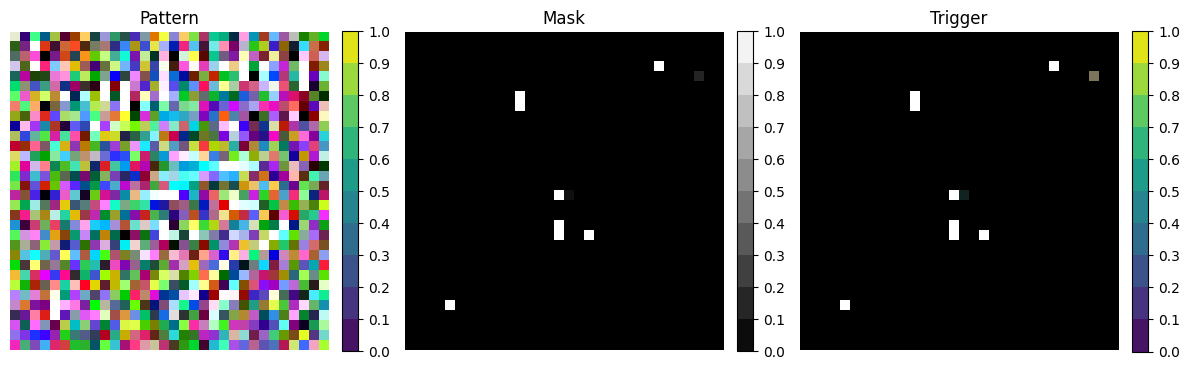


----- Optimizing for label 2, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 90.6983
Cross-entropy loss: 37.0936
Regularization loss: 536.0472

Epoch 0, Batch iteration 40:
Total loss: 68.9753
Cross-entropy loss: 15.6697
Regularization loss: 533.0566

Epoch 0, Batch iteration 80:
Total loss: 60.9956
Cross-entropy loss: 8.0634
Regularization loss: 529.3221

Epoch 0, Batch iteration 120:
Total loss: 57.8095
Cross-entropy loss: 5.4621
Regularization loss: 523.4740

Epoch 1, Batch iteration 0:
Total loss: 53.9268
Cross-entropy loss: 2.1379
Regularization loss: 517.8889

Epoch 1, Batch iteration 40:
Total loss: 54.2730
Cross-entropy loss: 3.3247
Regularization loss: 509.4827

Epoch 1, Batch iteration 80:
Total loss: 51.8292
Cross-entropy loss: 1.8367
Regularization loss: 499.9247

Epoch 1, Batch iteration 120:
Total loss: 49.6322
Cross-entropy loss: 0.6921
Regularization loss: 489.4012

Epoch 2, Batch iteration 0:
Total loss: 51.0192
Cross-entropy loss: 2.9278
Regularization loss

Optimization time: 302.10 seconds



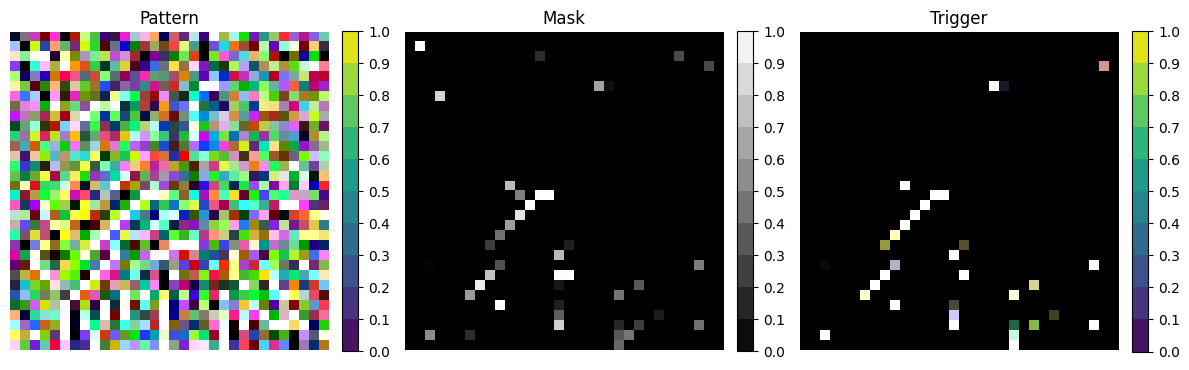


----- Optimizing for label 2, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 92.9147
Cross-entropy loss: 39.9929
Regularization loss: 529.2186

Epoch 0, Batch iteration 40:
Total loss: 65.6566
Cross-entropy loss: 13.0358
Regularization loss: 526.2077

Epoch 0, Batch iteration 80:
Total loss: 60.4422
Cross-entropy loss: 8.2170
Regularization loss: 522.2516

Epoch 0, Batch iteration 120:
Total loss: 55.3203
Cross-entropy loss: 3.6755
Regularization loss: 516.4480

Epoch 1, Batch iteration 0:
Total loss: 54.0092
Cross-entropy loss: 2.9293
Regularization loss: 510.7988

Epoch 1, Batch iteration 40:
Total loss: 53.3771
Cross-entropy loss: 3.1543
Regularization loss: 502.2283

Epoch 1, Batch iteration 80:
Total loss: 50.4322
Cross-entropy loss: 1.1943
Regularization loss: 492.3785

Epoch 1, Batch iteration 120:
Total loss: 48.4948
Cross-entropy loss: 0.3059
Regularization loss: 481.8892

Epoch 2, Batch iteration 0:
Total loss: 50.1516
Cross-entropy loss: 2.8178
Regularization loss

Optimization time: 302.90 seconds



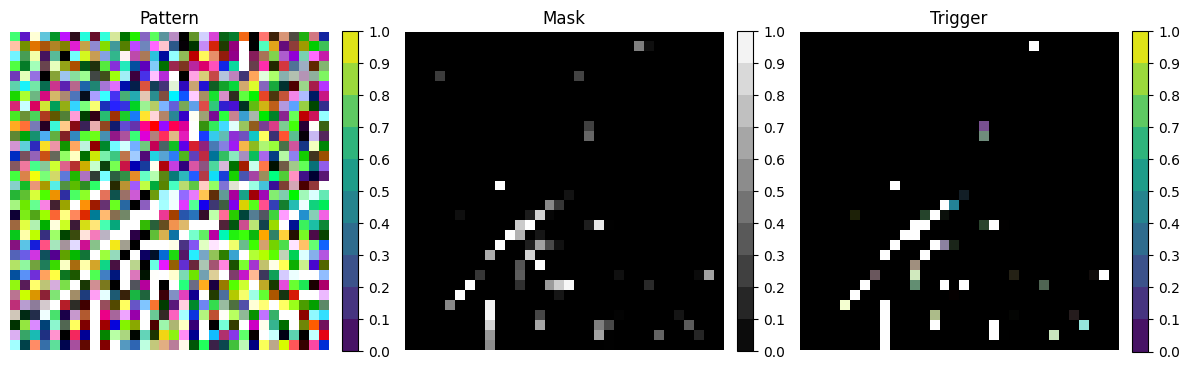


----- Optimizing for label 2, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 87.5508
Cross-entropy loss: 36.7017
Regularization loss: 508.4908

Epoch 0, Batch iteration 40:
Total loss: 62.0170
Cross-entropy loss: 11.5189
Regularization loss: 504.9809

Epoch 0, Batch iteration 80:
Total loss: 58.3755
Cross-entropy loss: 8.3513
Regularization loss: 500.2421

Epoch 0, Batch iteration 120:
Total loss: 52.4854
Cross-entropy loss: 3.0984
Regularization loss: 493.8695

Epoch 1, Batch iteration 0:
Total loss: 51.0803
Cross-entropy loss: 2.3121
Regularization loss: 487.6823

Epoch 1, Batch iteration 40:
Total loss: 49.8703
Cross-entropy loss: 2.0645
Regularization loss: 478.0573

Epoch 1, Batch iteration 80:
Total loss: 47.7904
Cross-entropy loss: 1.0381
Regularization loss: 467.5223

Epoch 1, Batch iteration 120:
Total loss: 46.4373
Cross-entropy loss: 0.8333
Regularization loss: 456.0402

Epoch 2, Batch iteration 0:
Total loss: 46.6936
Cross-entropy loss: 2.0053
Regularization loss

Early stopping triggered.
Optimization time: 161.00 seconds



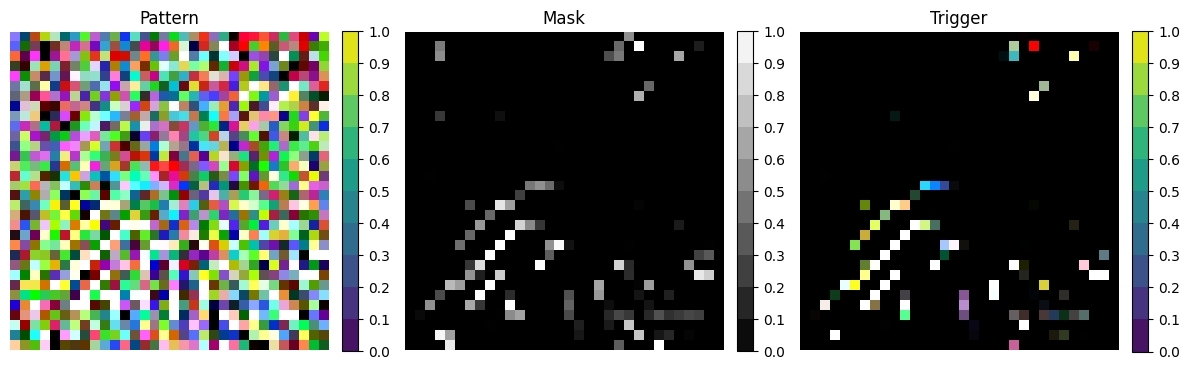


----- Optimizing for label 3, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 82.6239
Cross-entropy loss: 29.1394
Regularization loss: 534.8444

Epoch 0, Batch iteration 40:
Total loss: 58.1077
Cross-entropy loss: 5.0854
Regularization loss: 530.2235

Epoch 0, Batch iteration 80:
Total loss: 57.7113
Cross-entropy loss: 5.3604
Regularization loss: 523.5095

Epoch 0, Batch iteration 120:
Total loss: 55.7219
Cross-entropy loss: 4.2668
Regularization loss: 514.5510

Epoch 1, Batch iteration 0:
Total loss: 54.1020
Cross-entropy loss: 3.4295
Regularization loss: 506.7249

Epoch 1, Batch iteration 40:
Total loss: 51.3213
Cross-entropy loss: 1.8115
Regularization loss: 495.0987

Epoch 1, Batch iteration 80:
Total loss: 50.0015
Cross-entropy loss: 1.7660
Regularization loss: 482.3553

Epoch 1, Batch iteration 120:
Total loss: 47.8557
Cross-entropy loss: 0.9722
Regularization loss: 468.8346

Epoch 2, Batch iteration 0:
Total loss: 46.1869
Cross-entropy loss: 0.4017
Regularization loss:

Epoch 33, Batch iteration 120:
Total loss: 0.7825
Cross-entropy loss: 0.0000
Regularization loss: 7.8246

Early stopping triggered.
Optimization time: 257.46 seconds



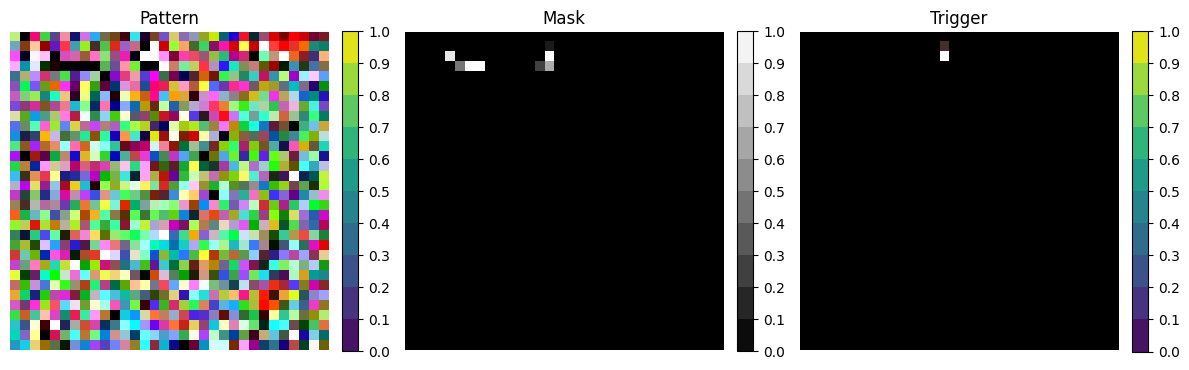


----- Optimizing for label 3, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 80.3910
Cross-entropy loss: 28.6695
Regularization loss: 517.2151

Epoch 0, Batch iteration 40:
Total loss: 56.3288
Cross-entropy loss: 5.1668
Regularization loss: 511.6210

Epoch 0, Batch iteration 80:
Total loss: 54.7653
Cross-entropy loss: 4.3463
Regularization loss: 504.1896

Epoch 0, Batch iteration 120:
Total loss: 52.7027
Cross-entropy loss: 3.2167
Regularization loss: 494.8597

Epoch 1, Batch iteration 0:
Total loss: 53.8431
Cross-entropy loss: 5.1661
Regularization loss: 486.7698

Epoch 1, Batch iteration 40:
Total loss: 49.1644
Cross-entropy loss: 1.6708
Regularization loss: 474.9355

Epoch 1, Batch iteration 80:
Total loss: 48.0040
Cross-entropy loss: 1.7978
Regularization loss: 462.0613

Epoch 1, Batch iteration 120:
Total loss: 45.7247
Cross-entropy loss: 0.9017
Regularization loss: 448.2307

Epoch 2, Batch iteration 0:
Total loss: 45.0614
Cross-entropy loss: 1.3197
Regularization loss:

Early stopping triggered.
Optimization time: 216.96 seconds



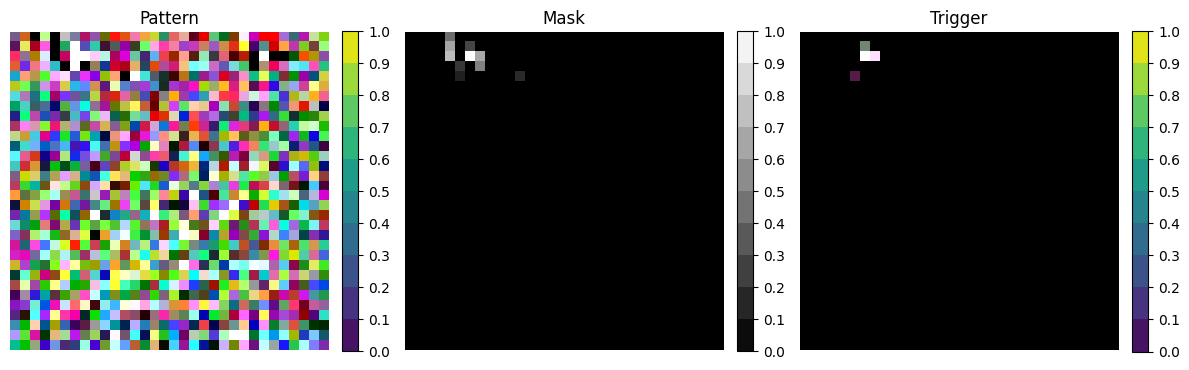


----- Optimizing for label 3, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 80.6372
Cross-entropy loss: 30.3006
Regularization loss: 503.3665

Epoch 0, Batch iteration 40:
Total loss: 57.5362
Cross-entropy loss: 7.6650
Regularization loss: 498.7122

Epoch 0, Batch iteration 80:
Total loss: 56.1846
Cross-entropy loss: 6.9795
Regularization loss: 492.0510

Epoch 0, Batch iteration 120:
Total loss: 52.9438
Cross-entropy loss: 4.5833
Regularization loss: 483.6054

Epoch 1, Batch iteration 0:
Total loss: 51.4009
Cross-entropy loss: 3.7500
Regularization loss: 476.5085

Epoch 1, Batch iteration 40:
Total loss: 49.3038
Cross-entropy loss: 2.6956
Regularization loss: 466.0817

Epoch 1, Batch iteration 80:
Total loss: 49.6449
Cross-entropy loss: 4.1879
Regularization loss: 454.5695

Epoch 1, Batch iteration 120:
Total loss: 45.7133
Cross-entropy loss: 1.4994
Regularization loss: 442.1392

Epoch 2, Batch iteration 0:
Total loss: 44.1524
Cross-entropy loss: 0.9194
Regularization loss:

Early stopping triggered.
Optimization time: 243.57 seconds



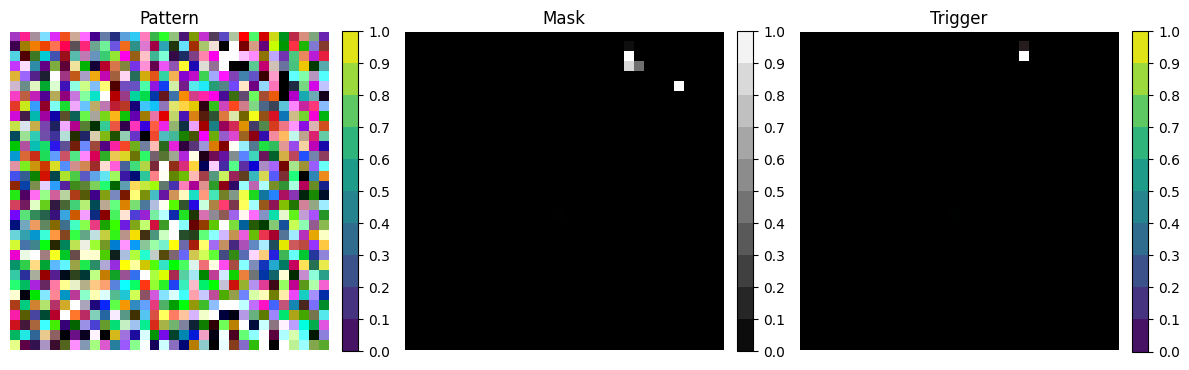


----- Optimizing for label 4, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 80.8374
Cross-entropy loss: 28.9767
Regularization loss: 518.6074

Epoch 0, Batch iteration 40:
Total loss: 59.9850
Cross-entropy loss: 8.4674
Regularization loss: 515.1758

Epoch 0, Batch iteration 80:
Total loss: 57.0398
Cross-entropy loss: 6.0519
Regularization loss: 509.8789

Epoch 0, Batch iteration 120:
Total loss: 51.0569
Cross-entropy loss: 0.8912
Regularization loss: 501.6574

Epoch 1, Batch iteration 0:
Total loss: 50.8353
Cross-entropy loss: 1.4358
Regularization loss: 493.9957

Epoch 1, Batch iteration 40:
Total loss: 49.2985
Cross-entropy loss: 1.0742
Regularization loss: 482.2438

Epoch 1, Batch iteration 80:
Total loss: 47.4787
Cross-entropy loss: 0.5311
Regularization loss: 469.4752

Epoch 1, Batch iteration 120:
Total loss: 46.1751
Cross-entropy loss: 0.5560
Regularization loss: 456.1915

Epoch 2, Batch iteration 0:
Total loss: 45.8713
Cross-entropy loss: 1.3076
Regularization loss:

Optimization time: 304.66 seconds



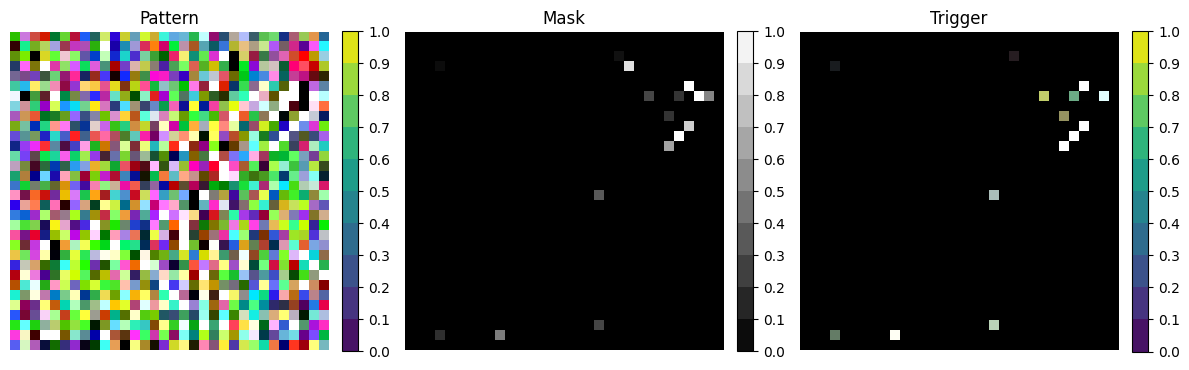


----- Optimizing for label 4, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 92.7007
Cross-entropy loss: 42.3603
Regularization loss: 503.4039

Epoch 0, Batch iteration 40:
Total loss: 62.0390
Cross-entropy loss: 12.0863
Regularization loss: 499.5270

Epoch 0, Batch iteration 80:
Total loss: 57.2586
Cross-entropy loss: 7.6836
Regularization loss: 495.7500

Epoch 0, Batch iteration 120:
Total loss: 51.8400
Cross-entropy loss: 2.8992
Regularization loss: 489.4078

Epoch 1, Batch iteration 0:
Total loss: 50.9138
Cross-entropy loss: 2.5799
Regularization loss: 483.3395

Epoch 1, Batch iteration 40:
Total loss: 49.6483
Cross-entropy loss: 2.2644
Regularization loss: 473.8387

Epoch 1, Batch iteration 80:
Total loss: 47.7574
Cross-entropy loss: 1.4586
Regularization loss: 462.9884

Epoch 1, Batch iteration 120:
Total loss: 45.5616
Cross-entropy loss: 0.4225
Regularization loss: 451.3908

Epoch 2, Batch iteration 0:
Total loss: 45.2459
Cross-entropy loss: 1.0453
Regularization loss

Early stopping triggered.
Optimization time: 208.94 seconds



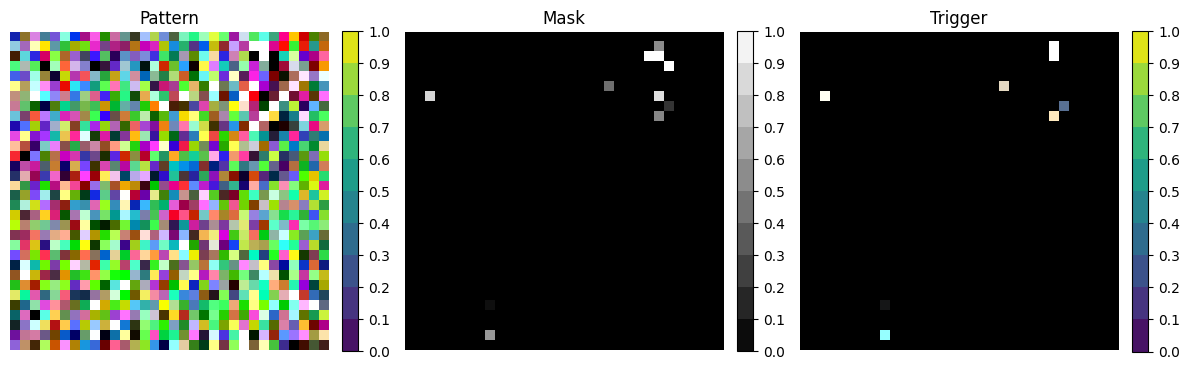


----- Optimizing for label 4, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 86.1972
Cross-entropy loss: 35.5704
Regularization loss: 506.2683

Epoch 0, Batch iteration 40:
Total loss: 58.8224
Cross-entropy loss: 8.5620
Regularization loss: 502.6038

Epoch 0, Batch iteration 80:
Total loss: 55.3161
Cross-entropy loss: 5.5860
Regularization loss: 497.3008

Epoch 0, Batch iteration 120:
Total loss: 50.7352
Cross-entropy loss: 1.7736
Regularization loss: 489.6160

Epoch 1, Batch iteration 0:
Total loss: 50.7781
Cross-entropy loss: 2.5128
Regularization loss: 482.6536

Epoch 1, Batch iteration 40:
Total loss: 48.0087
Cross-entropy loss: 0.7890
Regularization loss: 472.1969

Epoch 1, Batch iteration 80:
Total loss: 47.2732
Cross-entropy loss: 1.2220
Regularization loss: 460.5117

Epoch 1, Batch iteration 120:
Total loss: 45.7004
Cross-entropy loss: 0.8864
Regularization loss: 448.1402

Epoch 2, Batch iteration 0:
Total loss: 44.9021
Cross-entropy loss: 1.0696
Regularization loss:

Optimization time: 307.12 seconds



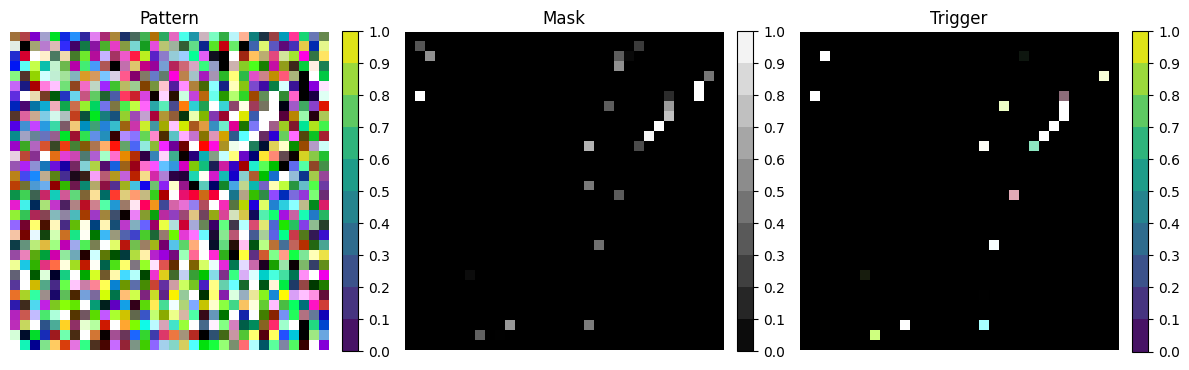


----- Optimizing for label 5, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 94.2332
Cross-entropy loss: 41.6816
Regularization loss: 525.5156

Epoch 0, Batch iteration 40:
Total loss: 64.8084
Cross-entropy loss: 12.5700
Regularization loss: 522.3833

Epoch 0, Batch iteration 80:
Total loss: 60.5051
Cross-entropy loss: 8.6824
Regularization loss: 518.2263

Epoch 0, Batch iteration 120:
Total loss: 55.0086
Cross-entropy loss: 3.8008
Regularization loss: 512.0779

Epoch 1, Batch iteration 0:
Total loss: 55.2451
Cross-entropy loss: 4.5939
Regularization loss: 506.5126

Epoch 1, Batch iteration 40:
Total loss: 54.3450
Cross-entropy loss: 4.5277
Regularization loss: 498.1730

Epoch 1, Batch iteration 80:
Total loss: 50.1896
Cross-entropy loss: 1.3158
Regularization loss: 488.7378

Epoch 1, Batch iteration 120:
Total loss: 50.4382
Cross-entropy loss: 2.5978
Regularization loss: 478.4037

Epoch 2, Batch iteration 0:
Total loss: 49.1667
Cross-entropy loss: 2.1523
Regularization loss

Early stopping triggered.
Optimization time: 299.84 seconds



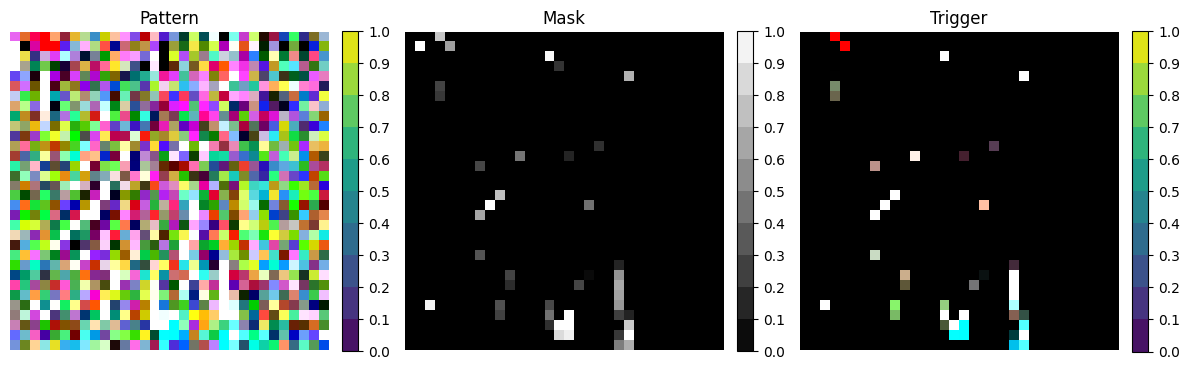


----- Optimizing for label 5, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 86.7147
Cross-entropy loss: 36.8783
Regularization loss: 498.3643

Epoch 0, Batch iteration 40:
Total loss: 62.3430
Cross-entropy loss: 12.8751
Regularization loss: 494.6792

Epoch 0, Batch iteration 80:
Total loss: 57.4328
Cross-entropy loss: 8.4048
Regularization loss: 490.2800

Epoch 0, Batch iteration 120:
Total loss: 52.7452
Cross-entropy loss: 4.3242
Regularization loss: 484.2099

Epoch 1, Batch iteration 0:
Total loss: 52.1687
Cross-entropy loss: 4.3269
Regularization loss: 478.4171

Epoch 1, Batch iteration 40:
Total loss: 50.3649
Cross-entropy loss: 3.3457
Regularization loss: 470.1924

Epoch 1, Batch iteration 80:
Total loss: 48.6739
Cross-entropy loss: 2.6301
Regularization loss: 460.4380

Epoch 1, Batch iteration 120:
Total loss: 47.4976
Cross-entropy loss: 2.4851
Regularization loss: 450.1250

Epoch 2, Batch iteration 0:
Total loss: 46.6501
Cross-entropy loss: 2.4675
Regularization loss

Optimization time: 307.53 seconds



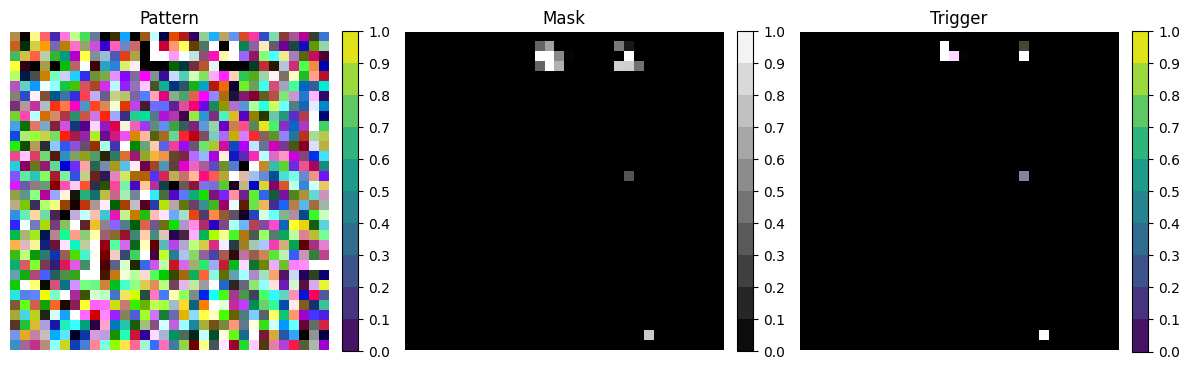


----- Optimizing for label 5, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 89.6043
Cross-entropy loss: 39.4737
Regularization loss: 501.3059

Epoch 0, Batch iteration 40:
Total loss: 63.3627
Cross-entropy loss: 13.6103
Regularization loss: 497.5239

Epoch 0, Batch iteration 80:
Total loss: 60.8223
Cross-entropy loss: 11.5353
Regularization loss: 492.8707

Epoch 0, Batch iteration 120:
Total loss: 54.2155
Cross-entropy loss: 5.4839
Regularization loss: 487.3154

Epoch 1, Batch iteration 0:
Total loss: 51.9316
Cross-entropy loss: 3.7152
Regularization loss: 482.1641

Epoch 1, Batch iteration 40:
Total loss: 52.5269
Cross-entropy loss: 5.0800
Regularization loss: 474.4689

Epoch 1, Batch iteration 80:
Total loss: 49.4457
Cross-entropy loss: 2.8622
Regularization loss: 465.8354

Epoch 1, Batch iteration 120:
Total loss: 48.1967
Cross-entropy loss: 2.5568
Regularization loss: 456.3992

Epoch 2, Batch iteration 0:
Total loss: 47.5956
Cross-entropy loss: 2.7151
Regularization los

Early stopping triggered.
Optimization time: 272.51 seconds



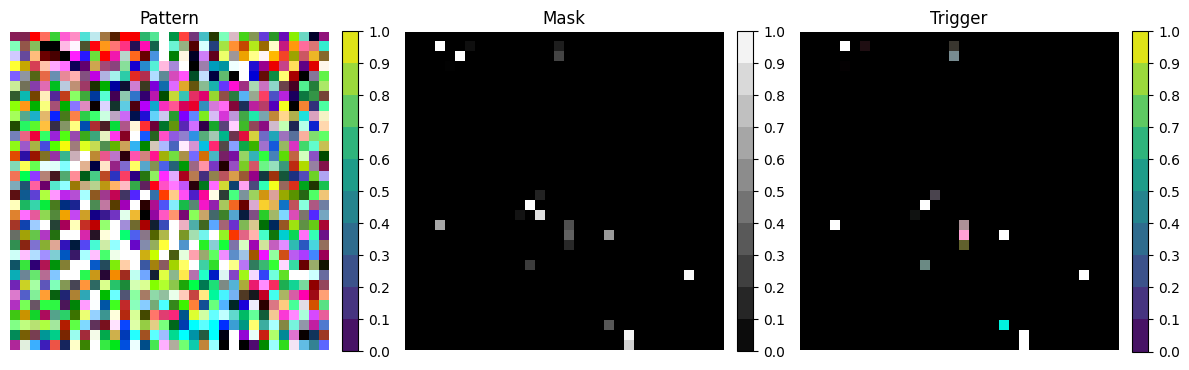


----- Optimizing for label 6, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 60.5188
Cross-entropy loss: 10.8131
Regularization loss: 497.0564

Epoch 0, Batch iteration 40:
Total loss: 51.2735
Cross-entropy loss: 2.5814
Regularization loss: 486.9214

Epoch 0, Batch iteration 80:
Total loss: 48.6282
Cross-entropy loss: 1.3610
Regularization loss: 472.6722

Epoch 0, Batch iteration 120:
Total loss: 46.8747
Cross-entropy loss: 1.2725
Regularization loss: 456.0215

Epoch 1, Batch iteration 0:
Total loss: 44.5977
Cross-entropy loss: 0.3366
Regularization loss: 442.6112

Epoch 1, Batch iteration 40:
Total loss: 42.5758
Cross-entropy loss: 0.1851
Regularization loss: 423.9063

Epoch 1, Batch iteration 80:
Total loss: 41.6551
Cross-entropy loss: 1.1936
Regularization loss: 404.6147

Epoch 1, Batch iteration 120:
Total loss: 39.0077
Cross-entropy loss: 0.4569
Regularization loss: 385.5087

Epoch 2, Batch iteration 0:
Total loss: 38.1178
Cross-entropy loss: 1.0049
Regularization loss:

Early stopping triggered.
Optimization time: 236.13 seconds



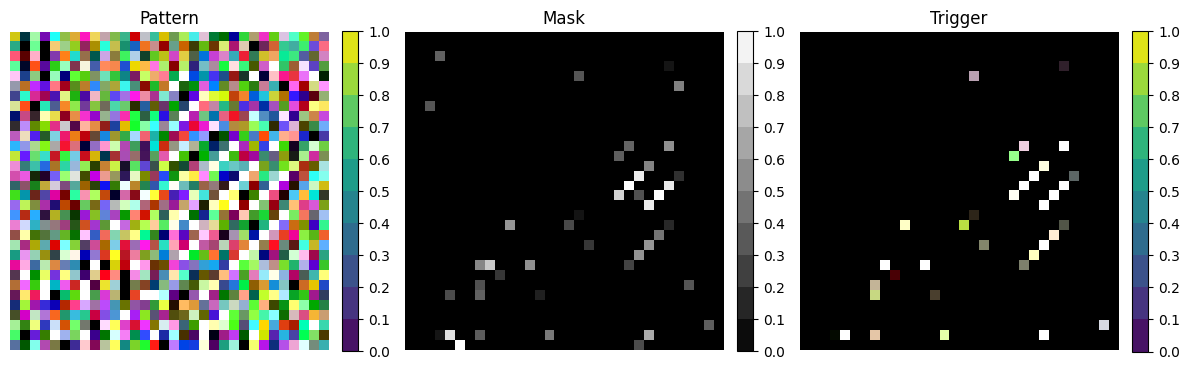


----- Optimizing for label 6, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 67.6510
Cross-entropy loss: 16.7849
Regularization loss: 508.6609

Epoch 0, Batch iteration 40:
Total loss: 52.7151
Cross-entropy loss: 2.5916
Regularization loss: 501.2354

Epoch 0, Batch iteration 80:
Total loss: 51.4688
Cross-entropy loss: 2.4467
Regularization loss: 490.2208

Epoch 0, Batch iteration 120:
Total loss: 48.7734
Cross-entropy loss: 1.1380
Regularization loss: 476.3545

Epoch 1, Batch iteration 0:
Total loss: 47.4559
Cross-entropy loss: 0.9679
Regularization loss: 464.8803

Epoch 1, Batch iteration 40:
Total loss: 45.7061
Cross-entropy loss: 0.8994
Regularization loss: 448.0670

Epoch 1, Batch iteration 80:
Total loss: 44.5416
Cross-entropy loss: 1.4821
Regularization loss: 430.5957

Epoch 1, Batch iteration 120:
Total loss: 41.6908
Cross-entropy loss: 0.4525
Regularization loss: 412.3837

Epoch 2, Batch iteration 0:
Total loss: 41.1769
Cross-entropy loss: 1.3193
Regularization loss:

Early stopping triggered.
Optimization time: 259.67 seconds



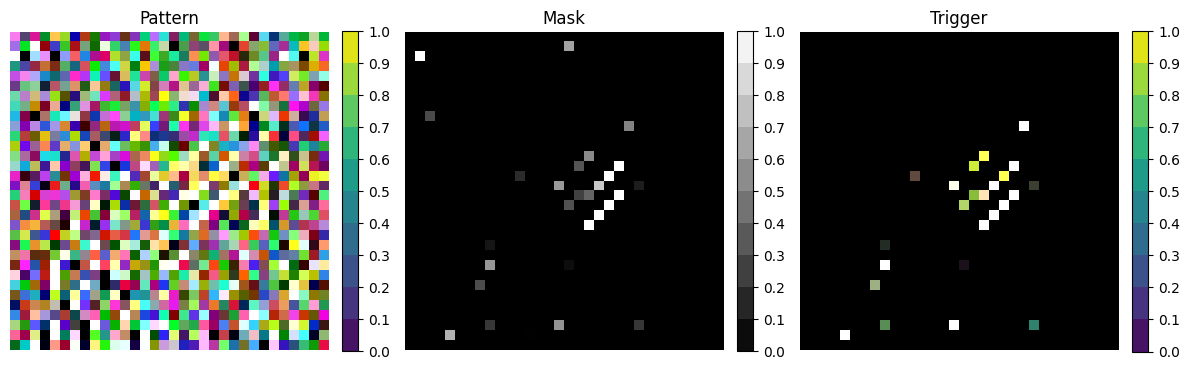


----- Optimizing for label 6, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 63.2222
Cross-entropy loss: 11.7488
Regularization loss: 514.7339

Epoch 0, Batch iteration 40:
Total loss: 52.9237
Cross-entropy loss: 2.3900
Regularization loss: 505.3370

Epoch 0, Batch iteration 80:
Total loss: 50.3158
Cross-entropy loss: 1.1870
Regularization loss: 491.2876

Epoch 0, Batch iteration 120:
Total loss: 48.0005
Cross-entropy loss: 0.5522
Regularization loss: 474.4831

Epoch 1, Batch iteration 0:
Total loss: 46.7996
Cross-entropy loss: 0.7179
Regularization loss: 460.8163

Epoch 1, Batch iteration 40:
Total loss: 44.7727
Cross-entropy loss: 0.5658
Regularization loss: 442.0697

Epoch 1, Batch iteration 80:
Total loss: 44.0546
Cross-entropy loss: 1.8184
Regularization loss: 422.3619

Epoch 1, Batch iteration 120:
Total loss: 40.7888
Cross-entropy loss: 0.5750
Regularization loss: 402.1383

Epoch 2, Batch iteration 0:
Total loss: 39.8888
Cross-entropy loss: 1.1594
Regularization loss:

Early stopping triggered.
Optimization time: 265.60 seconds



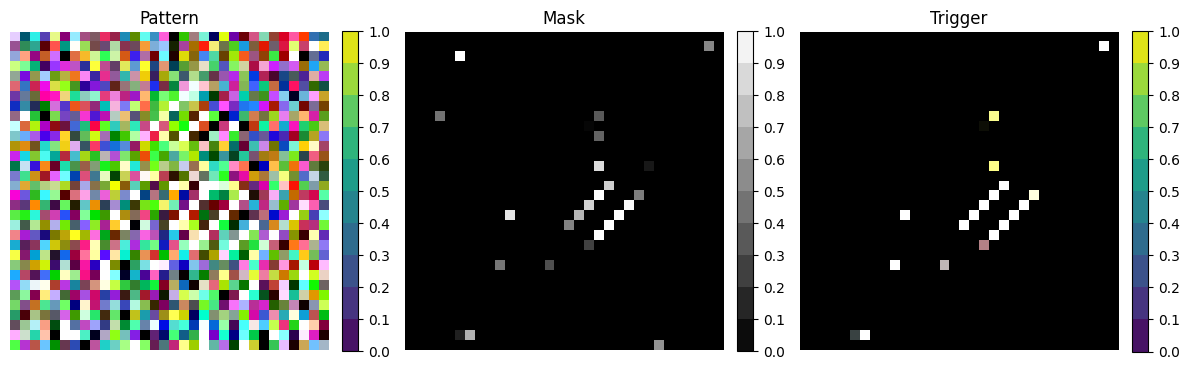


----- Optimizing for label 7, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 95.9426
Cross-entropy loss: 44.4053
Regularization loss: 515.3734

Epoch 0, Batch iteration 40:
Total loss: 68.7920
Cross-entropy loss: 17.5886
Regularization loss: 512.0341

Epoch 0, Batch iteration 80:
Total loss: 57.9572
Cross-entropy loss: 7.1405
Regularization loss: 508.1673

Epoch 0, Batch iteration 120:
Total loss: 51.7024
Cross-entropy loss: 1.4734
Regularization loss: 502.2895

Epoch 1, Batch iteration 0:
Total loss: 51.2448
Cross-entropy loss: 1.6045
Regularization loss: 496.4026

Epoch 1, Batch iteration 40:
Total loss: 50.0975
Cross-entropy loss: 1.4150
Regularization loss: 486.8251

Epoch 1, Batch iteration 80:
Total loss: 48.3804
Cross-entropy loss: 0.8046
Regularization loss: 475.7573

Epoch 1, Batch iteration 120:
Total loss: 46.9107
Cross-entropy loss: 0.5437
Regularization loss: 463.6700

Epoch 2, Batch iteration 0:
Total loss: 46.1430
Cross-entropy loss: 0.7321
Regularization loss

Early stopping triggered.
Optimization time: 234.07 seconds



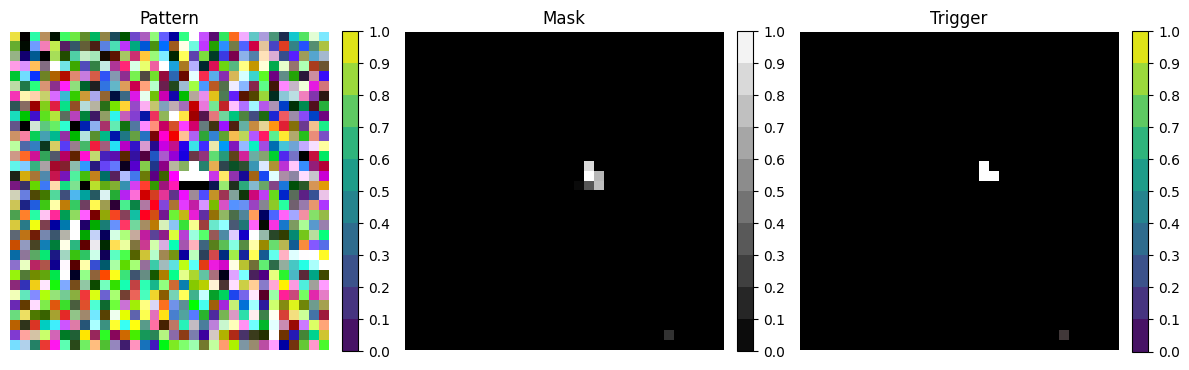


----- Optimizing for label 7, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 96.8033
Cross-entropy loss: 46.7757
Regularization loss: 500.2761

Epoch 0, Batch iteration 40:
Total loss: 65.9290
Cross-entropy loss: 16.1286
Regularization loss: 498.0038

Epoch 0, Batch iteration 80:
Total loss: 58.1158
Cross-entropy loss: 8.6332
Regularization loss: 494.8260

Epoch 0, Batch iteration 120:
Total loss: 51.3552
Cross-entropy loss: 2.4440
Regularization loss: 489.1124

Epoch 1, Batch iteration 0:
Total loss: 51.7071
Cross-entropy loss: 3.3416
Regularization loss: 483.6556

Epoch 1, Batch iteration 40:
Total loss: 49.5224
Cross-entropy loss: 1.9998
Regularization loss: 475.2260

Epoch 1, Batch iteration 80:
Total loss: 48.5564
Cross-entropy loss: 1.9741
Regularization loss: 465.8239

Epoch 1, Batch iteration 120:
Total loss: 46.3501
Cross-entropy loss: 0.8257
Regularization loss: 455.2446

Epoch 2, Batch iteration 0:
Total loss: 45.6320
Cross-entropy loss: 0.9603
Regularization loss

Early stopping triggered.
Optimization time: 306.50 seconds



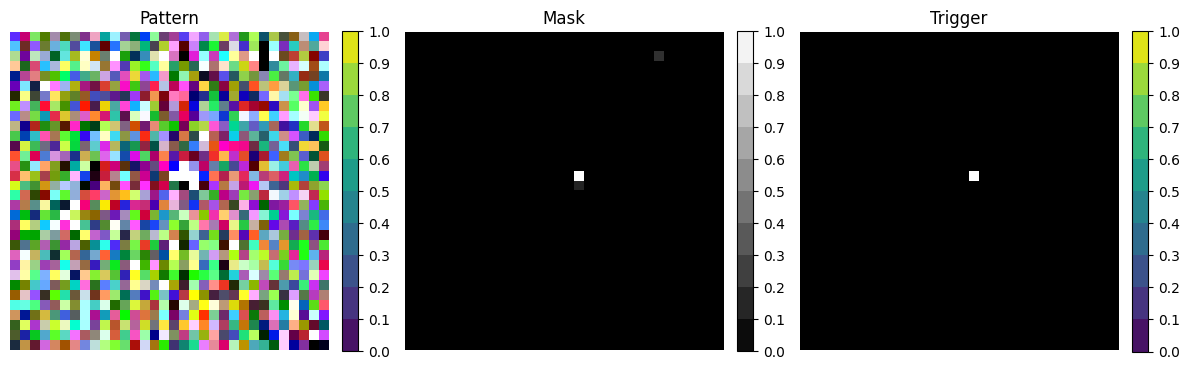


----- Optimizing for label 7, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 104.6107
Cross-entropy loss: 54.5275
Regularization loss: 500.8318

Epoch 0, Batch iteration 40:
Total loss: 70.4261
Cross-entropy loss: 20.5189
Regularization loss: 499.0714

Epoch 0, Batch iteration 80:
Total loss: 58.0524
Cross-entropy loss: 8.3259
Regularization loss: 497.2643

Epoch 0, Batch iteration 120:
Total loss: 51.9302
Cross-entropy loss: 2.5964
Regularization loss: 493.3377

Epoch 1, Batch iteration 0:
Total loss: 50.7738
Cross-entropy loss: 1.9050
Regularization loss: 488.6883

Epoch 1, Batch iteration 40:
Total loss: 49.6819
Cross-entropy loss: 1.5982
Regularization loss: 480.8369

Epoch 1, Batch iteration 80:
Total loss: 47.8596
Cross-entropy loss: 0.6944
Regularization loss: 471.6517

Epoch 1, Batch iteration 120:
Total loss: 46.2378
Cross-entropy loss: 0.0963
Regularization loss: 461.4149

Epoch 2, Batch iteration 0:
Total loss: 46.1629
Cross-entropy loss: 0.8472
Regularization los

Optimization time: 308.21 seconds



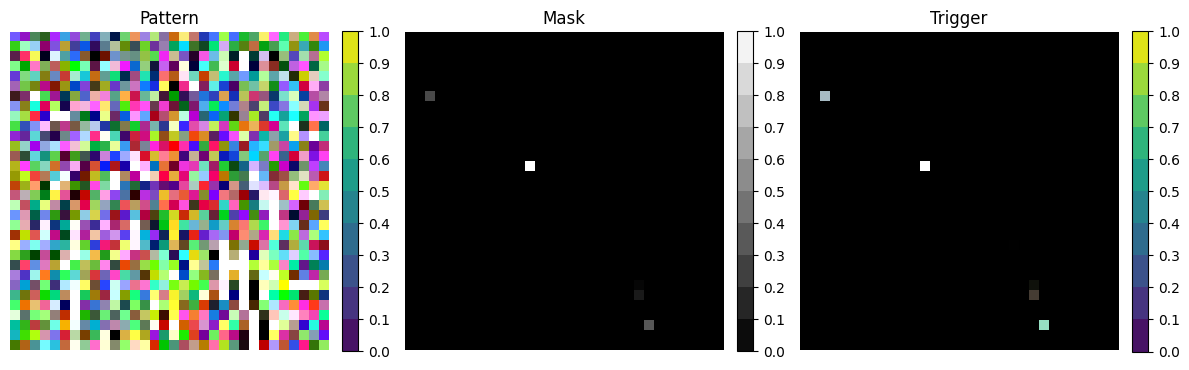


----- Optimizing for label 8, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 100.0813
Cross-entropy loss: 48.6489
Regularization loss: 514.3240

Epoch 0, Batch iteration 40:
Total loss: 68.7019
Cross-entropy loss: 17.5515
Regularization loss: 511.5045

Epoch 0, Batch iteration 80:
Total loss: 56.7481
Cross-entropy loss: 5.8571
Regularization loss: 508.9097

Epoch 0, Batch iteration 120:
Total loss: 54.3576
Cross-entropy loss: 3.9865
Regularization loss: 503.7117

Epoch 1, Batch iteration 0:
Total loss: 50.9732
Cross-entropy loss: 1.1194
Regularization loss: 498.5387

Epoch 1, Batch iteration 40:
Total loss: 50.7277
Cross-entropy loss: 1.6838
Regularization loss: 490.4395

Epoch 1, Batch iteration 80:
Total loss: 49.1918
Cross-entropy loss: 1.0688
Regularization loss: 481.2302

Epoch 1, Batch iteration 120:
Total loss: 47.3129
Cross-entropy loss: 0.1914
Regularization loss: 471.2149

Epoch 2, Batch iteration 0:
Total loss: 48.9048
Cross-entropy loss: 2.6092
Regularization los

Early stopping triggered.
Optimization time: 310.10 seconds



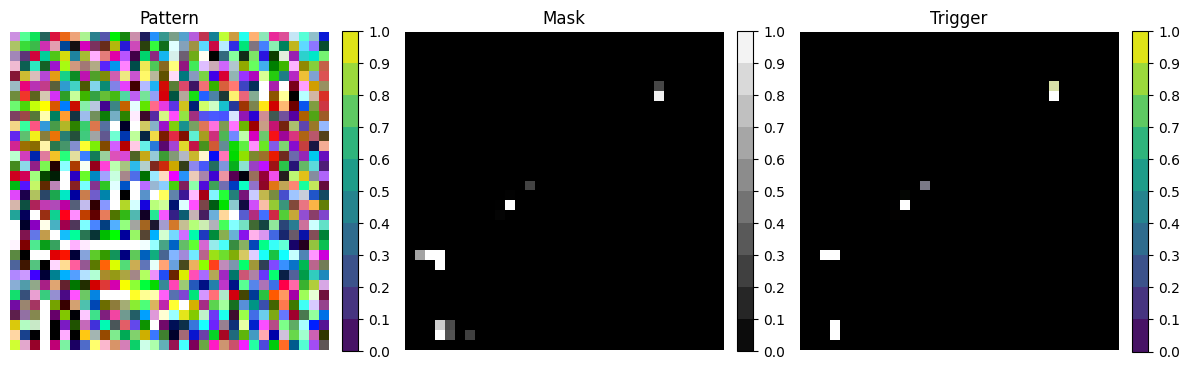


----- Optimizing for label 8, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 107.1057
Cross-entropy loss: 55.8244
Regularization loss: 512.8124

Epoch 0, Batch iteration 40:
Total loss: 79.1951
Cross-entropy loss: 28.1802
Regularization loss: 510.1487

Epoch 0, Batch iteration 80:
Total loss: 63.0685
Cross-entropy loss: 12.1940
Regularization loss: 508.7449

Epoch 0, Batch iteration 120:
Total loss: 55.5748
Cross-entropy loss: 4.9447
Regularization loss: 506.3013

Epoch 1, Batch iteration 0:
Total loss: 51.9025
Cross-entropy loss: 1.6604
Regularization loss: 502.4213

Epoch 1, Batch iteration 40:
Total loss: 51.7027
Cross-entropy loss: 2.1412
Regularization loss: 495.6152

Epoch 1, Batch iteration 80:
Total loss: 50.4708
Cross-entropy loss: 1.6989
Regularization loss: 487.7186

Epoch 1, Batch iteration 120:
Total loss: 48.2435
Cross-entropy loss: 0.3876
Regularization loss: 478.5595

Epoch 2, Batch iteration 0:
Total loss: 49.0373
Cross-entropy loss: 1.9600
Regularization lo

Optimization time: 311.83 seconds



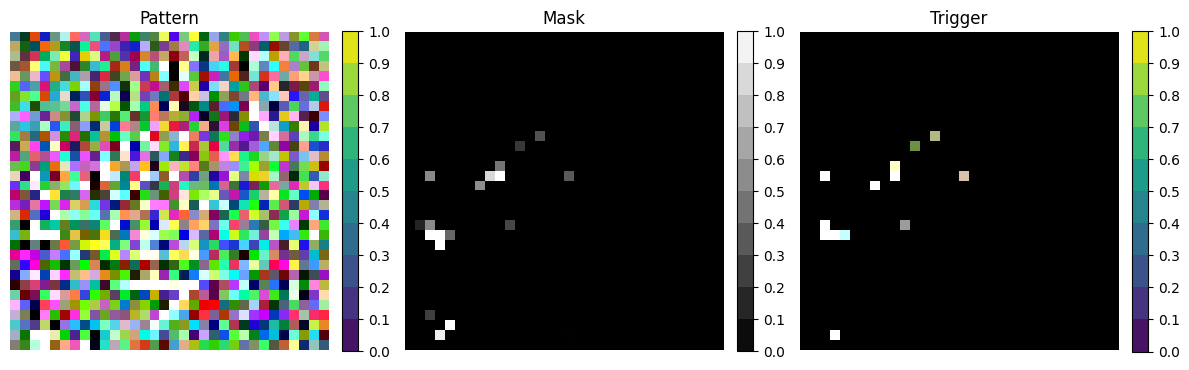


----- Optimizing for label 8, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 97.5375
Cross-entropy loss: 46.5383
Regularization loss: 509.9921

Epoch 0, Batch iteration 40:
Total loss: 70.1062
Cross-entropy loss: 19.3530
Regularization loss: 507.5321

Epoch 0, Batch iteration 80:
Total loss: 60.8570
Cross-entropy loss: 10.3514
Regularization loss: 505.0555

Epoch 0, Batch iteration 120:
Total loss: 54.1152
Cross-entropy loss: 4.0533
Regularization loss: 500.6184

Epoch 1, Batch iteration 0:
Total loss: 50.8477
Cross-entropy loss: 1.2469
Regularization loss: 496.0081

Epoch 1, Batch iteration 40:
Total loss: 51.5730
Cross-entropy loss: 2.7755
Regularization loss: 487.9748

Epoch 1, Batch iteration 80:
Total loss: 49.5697
Cross-entropy loss: 1.7131
Regularization loss: 478.5654

Epoch 1, Batch iteration 120:
Total loss: 47.8647
Cross-entropy loss: 1.0576
Regularization loss: 468.0712

Epoch 2, Batch iteration 0:
Total loss: 47.8767
Cross-entropy loss: 1.9172
Regularization los

Early stopping triggered.
Optimization time: 281.24 seconds



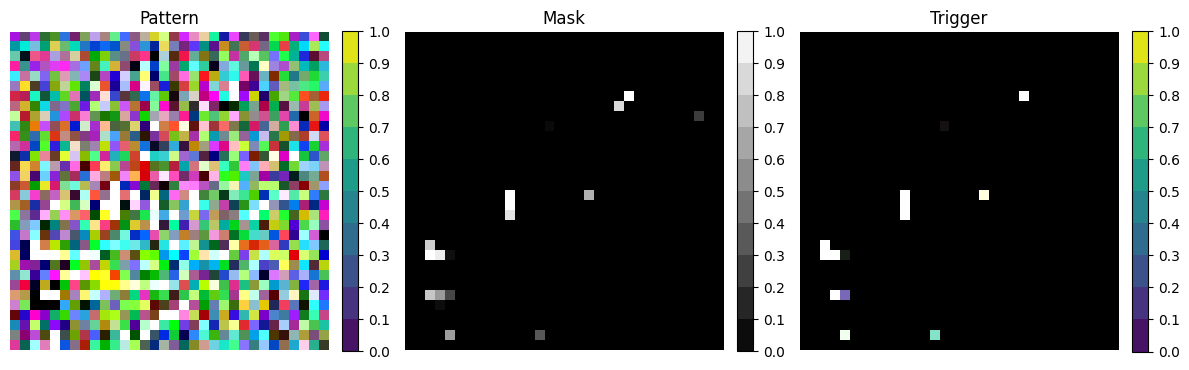


----- Optimizing for label 9, trial 1/3 -----

Epoch 0, Batch iteration 0:
Total loss: 63.1964
Cross-entropy loss: 11.9214
Regularization loss: 512.7506

Epoch 0, Batch iteration 40:
Total loss: 54.0735
Cross-entropy loss: 3.6261
Regularization loss: 504.4742

Epoch 0, Batch iteration 80:
Total loss: 49.6968
Cross-entropy loss: 0.5254
Regularization loss: 491.7143

Epoch 0, Batch iteration 120:
Total loss: 48.5518
Cross-entropy loss: 0.9575
Regularization loss: 475.9438

Epoch 1, Batch iteration 0:
Total loss: 46.9401
Cross-entropy loss: 0.6394
Regularization loss: 463.0072

Epoch 1, Batch iteration 40:
Total loss: 45.2359
Cross-entropy loss: 0.7805
Regularization loss: 444.5543

Epoch 1, Batch iteration 80:
Total loss: 44.2888
Cross-entropy loss: 1.7217
Regularization loss: 425.6714

Epoch 1, Batch iteration 120:
Total loss: 41.5880
Cross-entropy loss: 0.9914
Regularization loss: 405.9651

Epoch 2, Batch iteration 0:
Total loss: 39.6153
Cross-entropy loss: 0.5012
Regularization loss:

Early stopping triggered.
Optimization time: 278.94 seconds



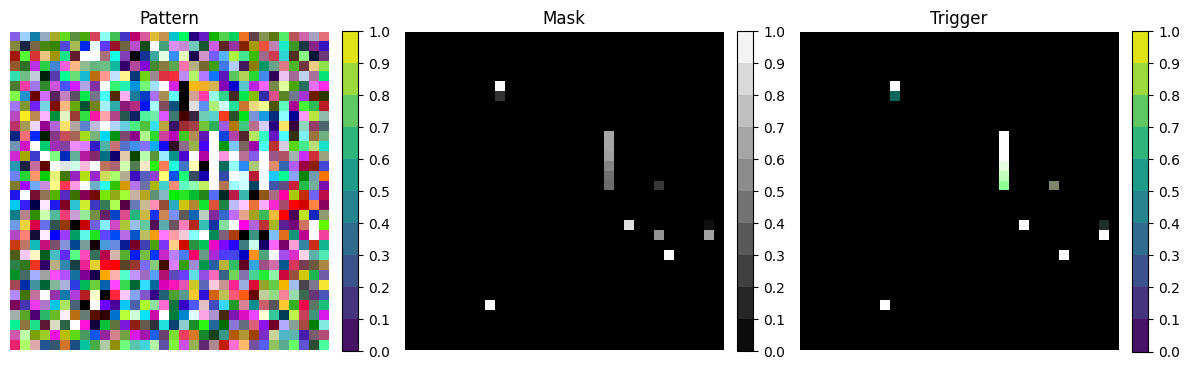


----- Optimizing for label 9, trial 2/3 -----

Epoch 0, Batch iteration 0:
Total loss: 84.3589
Cross-entropy loss: 33.9234
Regularization loss: 504.3548

Epoch 0, Batch iteration 40:
Total loss: 58.2249
Cross-entropy loss: 8.0590
Regularization loss: 501.6591

Epoch 0, Batch iteration 80:
Total loss: 50.5937
Cross-entropy loss: 1.0247
Regularization loss: 495.6896

Epoch 0, Batch iteration 120:
Total loss: 49.8392
Cross-entropy loss: 1.2203
Regularization loss: 486.1885

Epoch 1, Batch iteration 0:
Total loss: 48.6177
Cross-entropy loss: 0.8191
Regularization loss: 477.9856

Epoch 1, Batch iteration 40:
Total loss: 47.3654
Cross-entropy loss: 0.7706
Regularization loss: 465.9488

Epoch 1, Batch iteration 80:
Total loss: 46.9045
Cross-entropy loss: 1.6251
Regularization loss: 452.7948

Epoch 1, Batch iteration 120:
Total loss: 44.5902
Cross-entropy loss: 0.7059
Regularization loss: 438.8431

Epoch 2, Batch iteration 0:
Total loss: 43.5401
Cross-entropy loss: 0.7310
Regularization loss:

Early stopping triggered.
Optimization time: 259.22 seconds



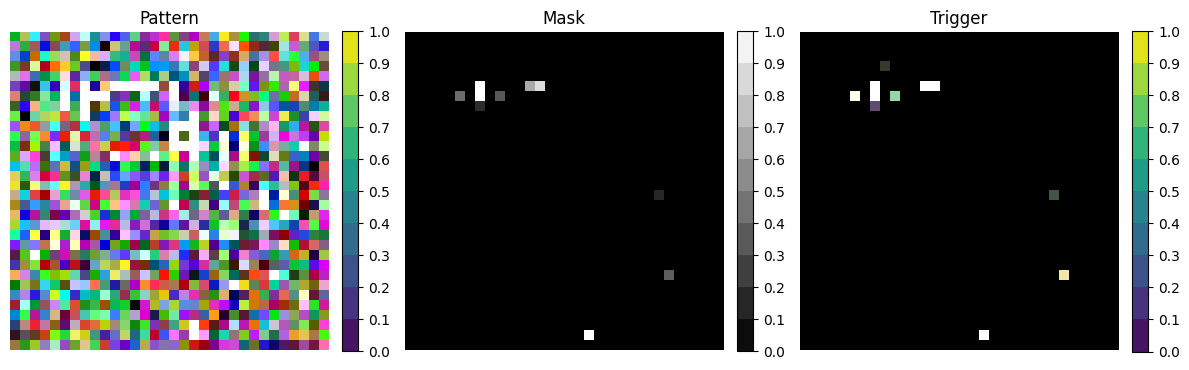


----- Optimizing for label 9, trial 3/3 -----

Epoch 0, Batch iteration 0:
Total loss: 67.0231
Cross-entropy loss: 16.0292
Regularization loss: 509.9383

Epoch 0, Batch iteration 40:
Total loss: 55.9541
Cross-entropy loss: 5.5395
Regularization loss: 504.1459

Epoch 0, Batch iteration 80:
Total loss: 50.3967
Cross-entropy loss: 0.9368
Regularization loss: 494.5988

Epoch 0, Batch iteration 120:
Total loss: 49.2233
Cross-entropy loss: 1.0446
Regularization loss: 481.7864

Epoch 1, Batch iteration 0:
Total loss: 47.8823
Cross-entropy loss: 0.7819
Regularization loss: 471.0038

Epoch 1, Batch iteration 40:
Total loss: 45.7835
Cross-entropy loss: 0.2421
Regularization loss: 455.4145

Epoch 1, Batch iteration 80:
Total loss: 44.8787
Cross-entropy loss: 0.9887
Regularization loss: 438.8993

Epoch 1, Batch iteration 120:
Total loss: 42.4902
Cross-entropy loss: 0.3230
Regularization loss: 421.6718

Epoch 2, Batch iteration 0:
Total loss: 41.3199
Cross-entropy loss: 0.4436
Regularization loss:

Epoch 35, Batch iteration 40:
Total loss: 1.2971
Cross-entropy loss: 0.3523
Regularization loss: 9.4480

Early stopping triggered.
Optimization time: 272.27 seconds



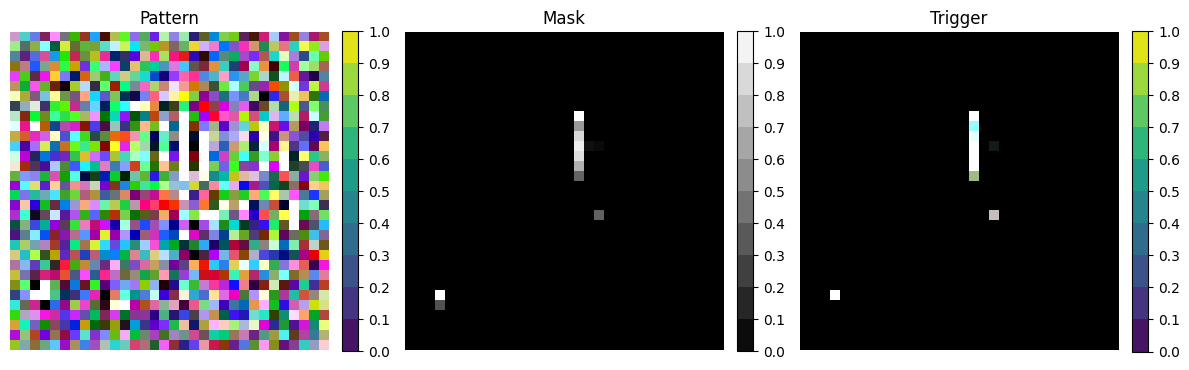



Total optimization time: 136 minutes, 11 seconds.


In [ ]:
reverse_engineered_triggers = reverse_engineer_triggers_for_all_labels(
  trainset = trainset,
  trainloader = trainloader,
  model = model,
  params = PARAMS,
  seed = SEED
)

# 3. Attack Success Rate (ASR) / Find the Best Trigger
**Note**: L1 norms for the trigger masks are calculated in this step as well (within the `select_best_trigger()` function)

In [ ]:
def calculate_attack_success_rate(model, testloader, trigger_pattern, trigger_mask, target_label):
  """
  Calculate the Attack Success Rate (ASR) for a given trigger using batches of test data from a DataLoader.

  Parameters:
  - model (torch.nn.Module): The model under attack.
  - testloader (DataLoader): DataLoader for the test data.
  - trigger_pattern (torch.Tensor): The trigger pattern to apply.
  - trigger_mask (torch.Tensor): The trigger mask to apply.
  - target_label (int): The label to which inputs should be misclassified.

  Returns:
  - float: The ASR of the trigger.
  """

  total_attacks = 0
  successful_attacks = 0

  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)

    # Filter images and labels where true label is not equal to target label
    valid_indices = (labels != target_label).nonzero(as_tuple = True)[0]
    images = images[valid_indices]
    labels = labels[valid_indices]

    # Apply the trigger to the images
    images_triggered = (1 - trigger_mask[None, :, :]) * images + trigger_mask[None, :, :] * trigger_pattern

    # Get the model's predictions
    logits = model(images_triggered)
    predictions = torch.argmax(logits, dim = 1)

    # Update the counts for successful attacks and total attacks
    successful_attacks += torch.sum(predictions == target_label).item()
    total_attacks += len(images)

  # Calculate the ASR
  asr = successful_attacks / total_attacks if total_attacks > 0 else 0

  return asr


def select_best_trigger(model, testloader, reverse_engineered_triggers):
  """
  Select the best reverse-engineered trigger for each label based on the highest ASR using a DataLoader.

  Parameters:
  - model (torch.nn.Module): The model under attack.
  - testloader (DataLoader): DataLoader for the test data.
  - reverse_engineered_triggers (dict): Dictionary containing reverse-engineered triggers for each label.

  Returns:
  - dict: Dictionary in which the key is the target label
          and the value is another dictionary with
          the best trigger object, its ASR, and mask L1 norm.
  """

  best_triggers = {}

  # Iterate through each target label and its corresponding triggers
  for target_label, triggers_list in reverse_engineered_triggers.items():
    max_asr = 0
    best_trigger = None
    min_l1_norm = float('inf')

    # Evaluate each trigger's ASR
    for trigger_obj in triggers_list:
      trigger_pattern = trigger_obj.pattern
      trigger_mask = trigger_obj.mask

      asr = calculate_attack_success_rate(
        model = model,
        testloader = testloader,
        trigger_pattern = trigger_pattern,
        trigger_mask = trigger_mask,
        target_label = target_label
      )

      # Calculate the L1 norm of the current trigger mask
      current_l1_norm = torch.sum(torch.abs(trigger_mask)).item()

      # Update the best trigger if the current trigger has a higher ASR or
      # if the ASR is the same but the mask L1 norm is smaller (and not zero)
      if asr > max_asr or (asr == max_asr and 0 < current_l1_norm < min_l1_norm):
        max_asr = asr
        best_trigger = trigger_obj
        min_l1_norm = current_l1_norm

      # Store the best trigger for the current label
      best_triggers[target_label] = {'Trigger': best_trigger, 'ASR': max_asr, 'Mask L1 norm': min_l1_norm}

  return best_triggers

In [ ]:
best_triggers = select_best_trigger(
  model = model,
  testloader = testloader,
  reverse_engineered_triggers = reverse_engineered_triggers
)


----- Best triggers for each class -----


Label: 0, Attack Success Rate: 99.83%



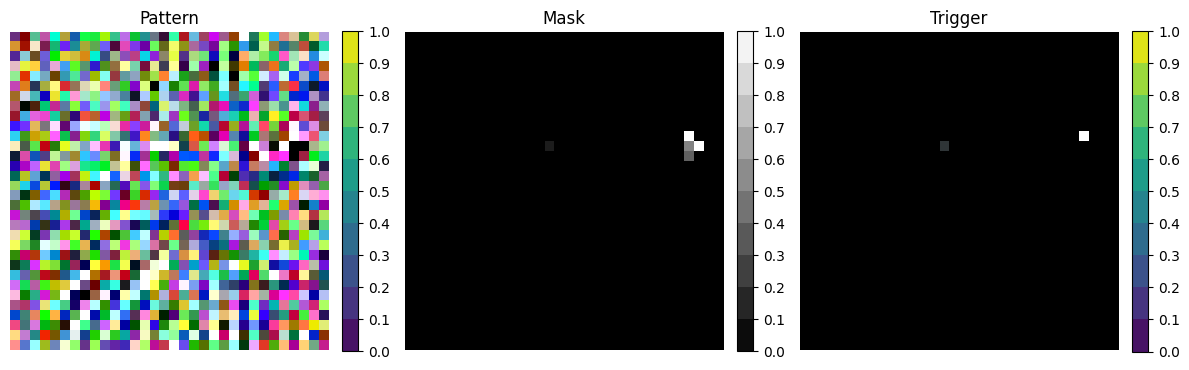



Label: 1, Attack Success Rate: 99.54%



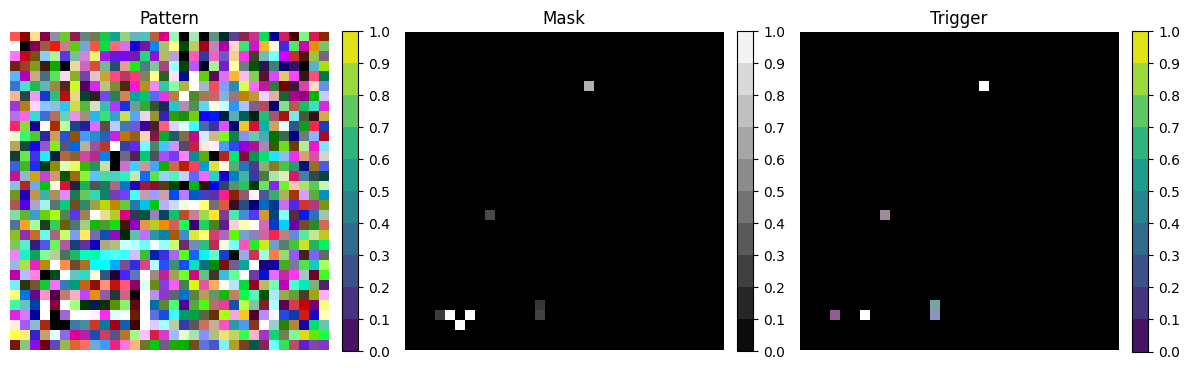



Label: 2, Attack Success Rate: 98.33%



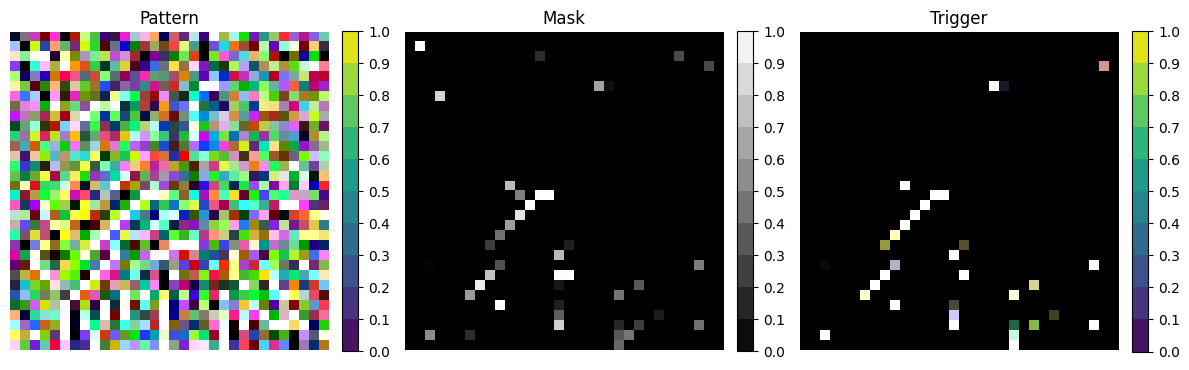



Label: 3, Attack Success Rate: 99.80%



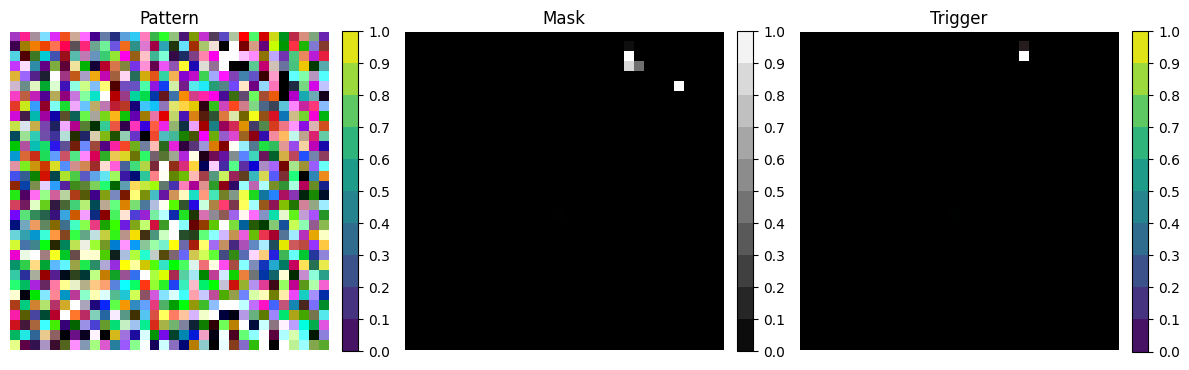



Label: 4, Attack Success Rate: 99.56%



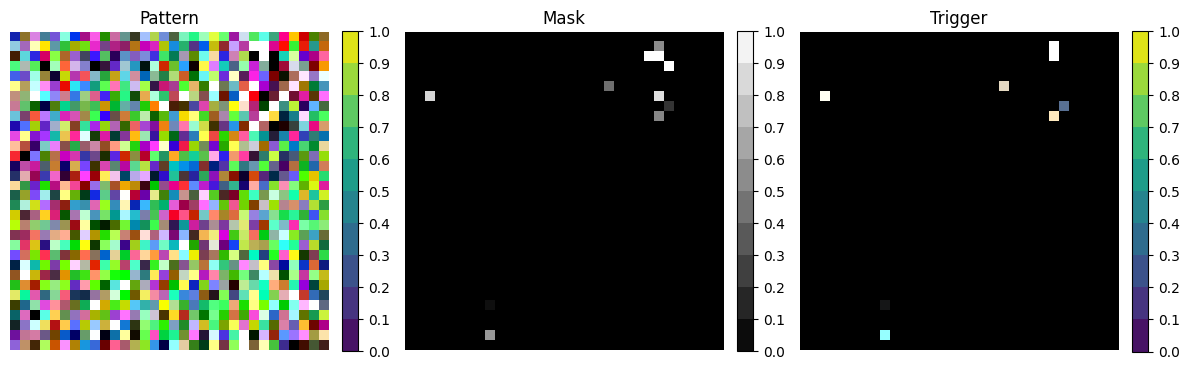



Label: 5, Attack Success Rate: 98.92%



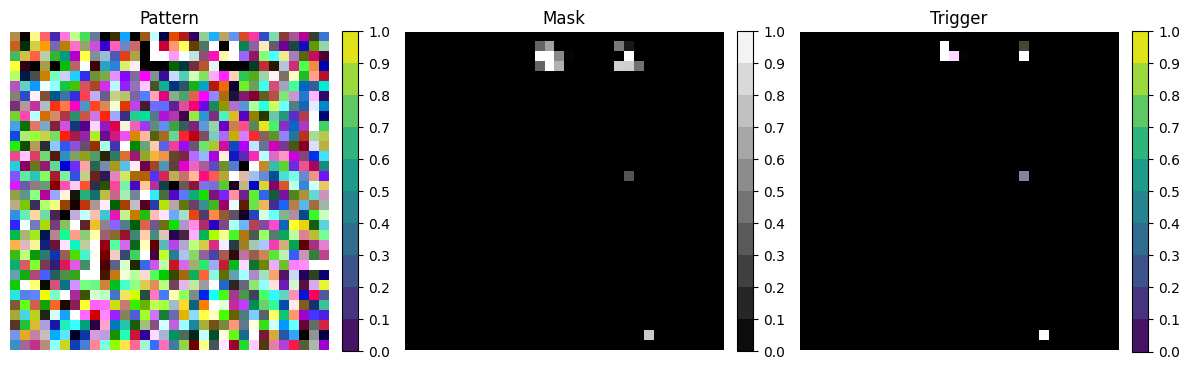



Label: 6, Attack Success Rate: 98.83%



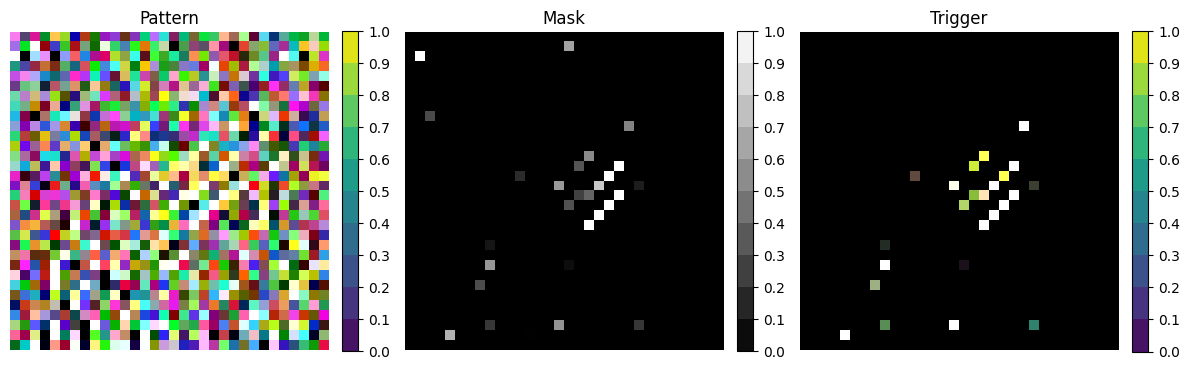



Label: 7, Attack Success Rate: 99.94%



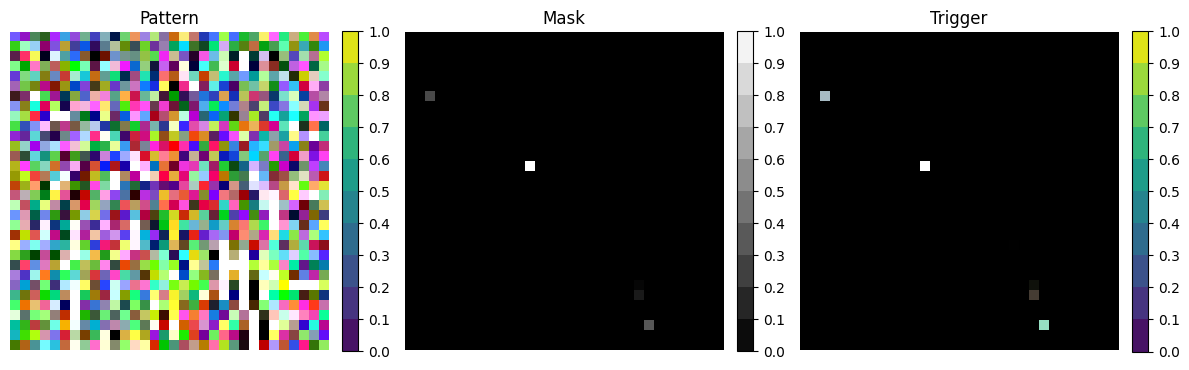



Label: 8, Attack Success Rate: 99.20%



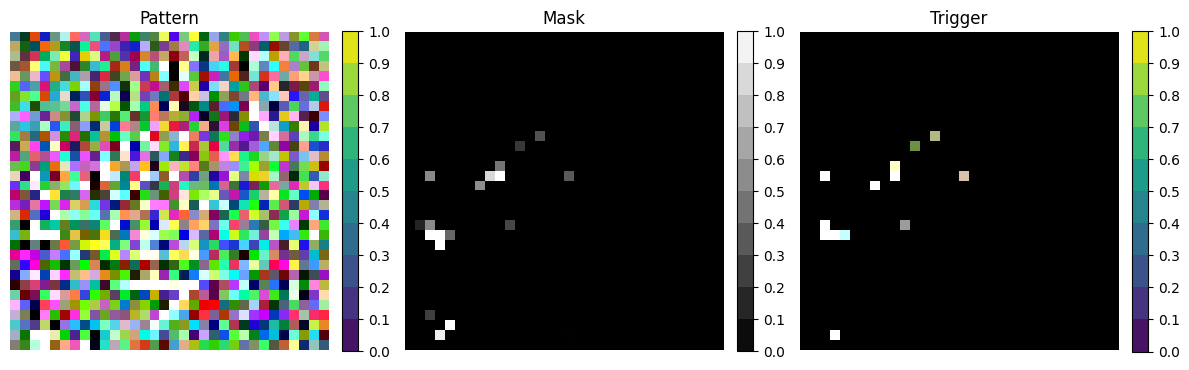



Label: 9, Attack Success Rate: 99.19%



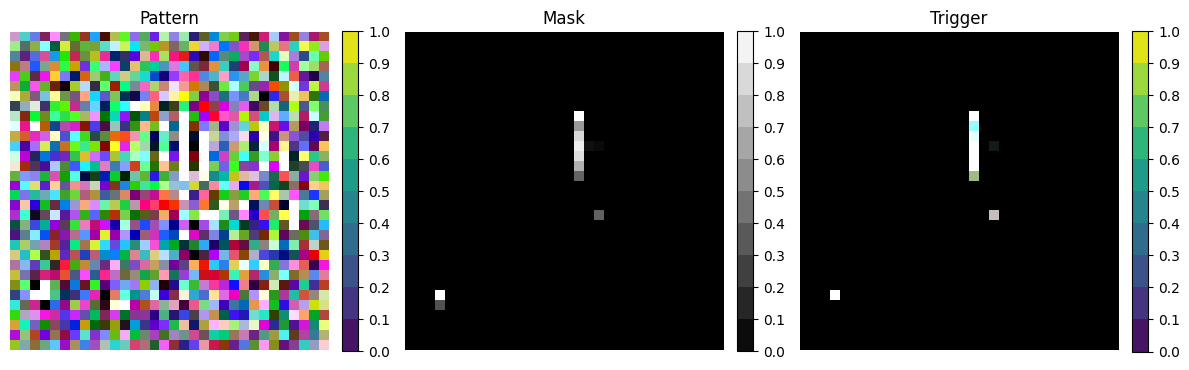

In [ ]:
# Visualize the best triggers
print("\n----- Best triggers for each class -----\n\n")

for target_label, best_trigger_dict in best_triggers.items():
  print(f"Label: {target_label}, Attack Success Rate: {best_trigger_dict['ASR'] * 100:.2f}%\n")

  best_trigger_dict['Trigger'].visualize_save_trigger(
    cmap_p = PARAMS['CMAP_P'],
    cmap_m = PARAMS['CMAP_M'],
    cmap_t = PARAMS['CMAP_T'],
    bg_color_p = PARAMS['BG_COLOR_P'],
    bg_color_m = PARAMS['BG_COLOR_M'],
    bg_color_t = PARAMS['BG_COLOR_T']
  )

  print(f"\n")

#4 MAD (Median Absolute Deviation) Outlier Detection
Using the mask L1 norms

In [ ]:
def mad_outlier_detection(best_triggers, threshold):
  """
  Detect outliers using the Median Absolute Deviation (MAD) method.

  Parameters:
  - best_triggers (dict): Dictionary in which the key is the target label
                          and the value is another dictionary with
                          the best trigger object and its ASR and mask L1 norm.
  - threshold (float): Threshold for the anomaly index.

  Returns:
  - outliers (dict): Dictionary of trigger
                      in which the key is the target label
                      and the value is another dictionary
                      with the best trigger object,
                      its ASR, mask L1 norm and anomaly index
                      and whether it's an outlier.
  """

  # Extract mask L1 norms from the best_triggers dictionary and convert to tensor
  l1_norms = torch.tensor([trigger_info['Mask L1 norm'] for trigger_info in best_triggers.values()])

  # Calculate the median of the mask L1 norms
  median_l1 = torch.median(l1_norms)

  # Compute the absolute deviation from the median for each mask L1 norm
  abs_deviation = torch.abs(l1_norms - median_l1)

  # Calculate the MAD
  mad = 1.4826 * torch.median(abs_deviation)

  # Calculate the anomaly index
  # Assuming the distribution is normal, a constant estimator (1.4826) is applied to normalize the anomaly index
  # Add a very small value to avoid division by zero
  anomaly_index = abs_deviation / (mad + 1e-10)

  print(f"Median of the mask L1 norms: {median_l1.item():.2f}")
  print(f"Median Absolute Deviation (MAD): {mad.item():.2f}")

  # Identify outliers
  outliers = {}
  for i, (target_label, trigger_info) in enumerate(best_triggers.items()):
    if anomaly_index[i].item() > threshold:
      outliers[target_label] = {
        'Trigger': trigger_info['Trigger'],
        'ASR': trigger_info['ASR'],
        'Mask L1 norm': trigger_info['Mask L1 norm'],
        'Anomaly index': anomaly_index[i].item(),
        'Outlier': 'Yes'
      }
    else:
      outliers[target_label] = {
        'Trigger': trigger_info['Trigger'],
        'ASR': trigger_info['ASR'],
        'Mask L1 norm': trigger_info['Mask L1 norm'],
        'Anomaly index': anomaly_index[i].item(),
        'Outlier': 'No'
      }

  return outliers

In [ ]:
best_trigger_outliers = mad_outlier_detection(
  best_triggers = best_triggers,
  threshold = PARAMS['MAD_THRESHOLD']
)

# Filter for outliers
final_triggers = {label: info for label, info in best_trigger_outliers.items() if info['Outlier'] == 'Yes'}

Median of the mask L1 norms: 9.40
Median Absolute Deviation (MAD): 5.17



----- Final triggers -----

Label 2:
- ASR: 98.33%
- Mask L1 norm: 25.38
- Anomaly index: 3.09
- Outlier: Yes



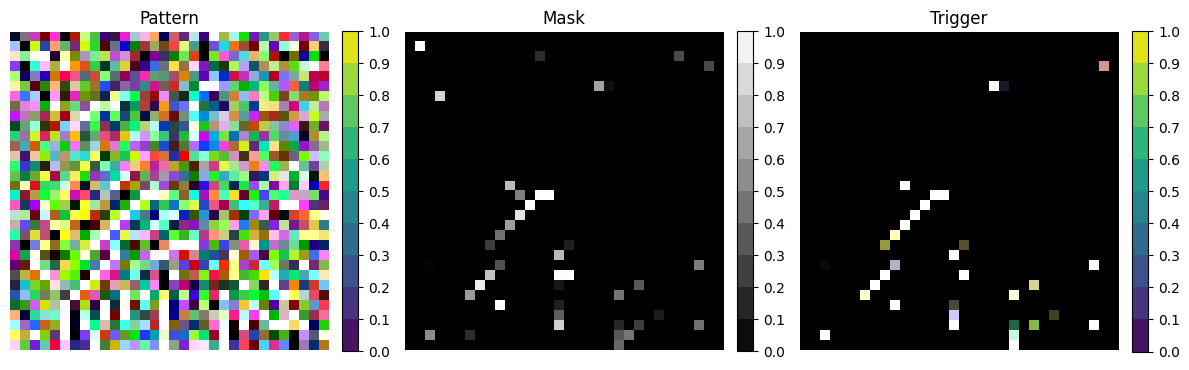

In [ ]:
# Visualize the final triggers outliers
print("\n----- Final triggers -----")

for target_label, trigger_info in final_triggers.items():
  print(f"\nLabel {target_label}:")
  print(f"- ASR: {trigger_info['ASR'] * 100:.2f}%")
  print(f"- Mask L1 norm: {trigger_info['Mask L1 norm']:.2f}")
  print(f"- Anomaly index: {trigger_info['Anomaly index']:.2f}")
  print(f"- Outlier: {trigger_info['Outlier']}\n")

  trigger_info['Trigger'].visualize_save_trigger(
    cmap_p = PARAMS['CMAP_P'],
    cmap_m = PARAMS['CMAP_M'],
    cmap_t = PARAMS['CMAP_T'],
    bg_color_p = PARAMS['BG_COLOR_P'],
    bg_color_m = PARAMS['BG_COLOR_M'],
    bg_color_t = PARAMS['BG_COLOR_T']
  )

# 5. Log Settings / Parameters / Triggers

In [ ]:
def log_experiment_results(model_name, dataset_name, seed, params, final_triggers, log_directory):
  """
  Log the experiment results including model info, parameters and trigger visualizations.

  Parameters:
  - model_name (str): Filename of the model being evaluated.
  - dataset_name (str): Name of the dataset used.
  - seed (int): Seed value used.
  - params (dict): Dictionary of parameters used.
  - final_triggers (dict): Dictionary of final triggers.
  - log_directory (str): Directory where the logs will be saved.
  """

  # Define the logging directory
  current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
  current_log_dir = os.path.join(log_directory, f'{current_time}_folder')

  # Create a new directory for the current run
  if not os.path.exists(current_log_dir):
    os.makedirs(current_log_dir)

  # Define the path for the .txt file
  txt_file_path = os.path.join(current_log_dir, 'info.txt')

  # Write information to the .txt file
  with open(txt_file_path, 'w') as f:
    f.write(f"Model: {model_name}\n")
    f.write(f"Dataset: {dataset_name}\n")
    f.write(f"Seed: {seed}\n")

    f.write("\n----- Parameters -----\n\n")
    for key, value in params.items():
        f.write(f"{key}: {value}\n")

    f.write("\n----- Triggers Info -----\n")
    for target_label, trigger_info in final_triggers.items():
      f.write(f"\nLabel {target_label}:\n")
      f.write(f"- ASR: {trigger_info['ASR'] * 100:.2f}%\n")
      f.write(f"- Mask L1 norm: {trigger_info['Mask L1 norm']:.2f}\n")
      f.write(f"- Anomaly index: {trigger_info['Anomaly index']:.2f}\n")
      f.write(f"- Outlier: {trigger_info['Outlier']}\n")

  # Save trigger visualizations as .png files using the provided method
  for target_label, trigger_info in final_triggers.items():
    trigger_png_path = os.path.join(current_log_dir, f"trigger_label_{target_label}.png")

    trigger_info['Trigger'].visualize_save_trigger(
      cmap_p = PARAMS['CMAP_P'],
      cmap_m = PARAMS['CMAP_M'],
      cmap_t = PARAMS['CMAP_T'],
      bg_color_p = PARAMS['BG_COLOR_P'],
      bg_color_m = PARAMS['BG_COLOR_M'],
      bg_color_t = PARAMS['BG_COLOR_T'],
      plot_fig = False,
      save_fig = True,
      save_path = trigger_png_path
    )

In [ ]:
# Define the LOG_DIR
log_dir = filepath + '_Logs'

# Call the function to log the results
log_experiment_results(
  model_name = model_name,
  dataset_name = dataset_name,
  seed = SEED,
  params = PARAMS,
  final_triggers = final_triggers,
  log_directory = log_dir
)